In [42]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    confusion_matrix as sk_confusion_matrix,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import StandardScaler
import logging
import time
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from catboost import CatBoostClassifier
from tensorflow.keras.utils import to_categorical 
import tensorflow as tf 
import logging
import gc 
import matplotlib.pyplot as plt

In [44]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [45]:
ENSEMBLE_WEIGHTS = [0.4, 0.3, 0.3]
num_classes = 7
epochs = 50
batch_size = 16
learning_rate = 0.001
all_possible_labels = list(range(num_classes))

In [46]:
def create_cnn_model_1(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    conv1 = Conv1D(filters=10, kernel_size=6, activation='relu', padding='same')(input_layer)
    conv2 = Conv1D(filters=10, kernel_size=6, activation='relu', padding='same')(conv1)
    pool = MaxPooling1D(pool_size=2, padding='same')(conv2)
    flatten = Flatten()(pool)
    dense1 = Dense(units=8, activation='relu')(flatten)
    output_layer = Dense(units=num_classes, activation='softmax', name='ecn2_output')(dense1)
    return Model(inputs=input_layer, outputs=output_layer)


def create_cnn_model_2(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    conv1 = Conv1D(filters=10, kernel_size=6, activation='relu', padding='same')(input_layer)
    conv2 = Conv1D(filters= 10, kernel_size=6, activation='relu', padding='same')(conv1)
    pool = MaxPooling1D(pool_size=2, padding='same')(conv2)
    flatten = Flatten()(pool)
    dense1 = Dense(units=8, activation='relu')(flatten)
    dropout1 = Dropout(0.5)(dense1)
    output_layer = Dense(units=num_classes, activation='softmax', name='ecn2_output')(dropout1)
    return Model(inputs=input_layer, outputs=output_layer)


def create_cnn_model_3(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    conv1 = Conv1D(filters=10, kernel_size=6, activation='relu', padding='same')(input_layer)
    conv2 = Conv1D(filters=10, kernel_size=6, activation='relu', padding='same')(conv1)
    pool = MaxPooling1D(pool_size=2, padding='same')(conv2)
    flatten = Flatten()(pool)
    output_layer = Dense(units=num_classes, activation='softmax', name='ecn3_output')(flatten)
    return Model(inputs=input_layer, outputs=output_layer)

In [47]:
def weighted_ensemble_predictions(predictions, weights):
    if len(predictions) != len(weights):
        raise ValueError("Number of models must match number of weights")
    weighted_predictions = np.array([predictions[i] * weights[i] for i in range(len(predictions))])
    ensemble_predictions = np.sum(weighted_predictions, axis=0)
    ensemble_predictions = np.argmax(ensemble_predictions, axis=1)
    return ensemble_predictions

In [48]:
def train_and_evaluate_cnn_ensemble(X_train, y_train, X_val, y_val, params):
    logging.info("Training CNN Ensemble...")

    X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else np.array(X_train)
    y_train_np = y_train.values if isinstance(y_train, pd.Series) else np.array(y_train)
    X_val_np = X_val.values if isinstance(X_val, pd.DataFrame) else np.array(X_val)
    y_val_np = y_val.values if isinstance(y_val, pd.Series) else np.array(y_val)

    y_train_np = y_train_np.astype(int)
    y_val_np = y_val_np.astype(int)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_np)
    X_val_scaled = scaler.transform(X_val_np)

    X_train_reshaped = np.expand_dims(X_train_scaled, axis=-1).astype(np.float32)
    X_val_reshaped = np.expand_dims(X_val_scaled, axis=-1).astype(np.float32)

    if X_train_reshaped.shape[1] == 0:
        logging.error("Error: X_train has 0 features after preprocessing/selection.")
        return None 
    input_shape = (X_train_reshaped.shape[1], 1)


    y_train_categorical = to_categorical(y_train_np, num_classes=num_classes)
    y_val_categorical = to_categorical(y_val_np, num_classes=num_classes) 

    cnn_model_1 = create_cnn_model_1(input_shape, num_classes)
    cnn_model_2 = create_cnn_model_2(input_shape, num_classes)
    cnn_model_3 = create_cnn_model_3(input_shape, num_classes)

    loss_function = 'categorical_crossentropy' 

    cnn_model_1.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss=loss_function, metrics=['accuracy'])
    cnn_model_2.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss=loss_function, metrics=['accuracy'])
    cnn_model_3.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss=loss_function, metrics=['accuracy'])

    train_start_time = time.time()
    logging.info("Fitting CNN Models...")
    history1 = cnn_model_1.fit(X_train_reshaped, y_train_categorical, epochs=params['epochs'],
                    batch_size=params['batch_size'], verbose=0,
                    validation_data=(X_val_reshaped, y_val_categorical)) 

    history2 = cnn_model_2.fit(X_train_reshaped, y_train_categorical, epochs=params['epochs'],
                    batch_size=params['batch_size'], verbose=0,
                    validation_data=(X_val_reshaped, y_val_categorical))

    history3 = cnn_model_3.fit(X_train_reshaped, y_train_categorical, epochs=params['epochs'],
                    batch_size=params['batch_size'], verbose=0,
                    validation_data=(X_val_reshaped, y_val_categorical))
    
    train_end_time = time.time()
    training_time = train_end_time - train_start_time
    logging.info(f"CNN Ensemble trained in {training_time:.2f} seconds.")
    
    predict_start_time = time.time()
    logging.info("Predicting with CNN Models...")
    cnn_predictions_1 = cnn_model_1.predict(X_val_reshaped, batch_size=params['batch_size'], verbose=0)
    cnn_predictions_2 = cnn_model_2.predict(X_val_reshaped, batch_size=params['batch_size'], verbose=0)
    cnn_predictions_3 = cnn_model_3.predict(X_val_reshaped, batch_size=params['batch_size'], verbose=0)

    ensemble_predictions = weighted_ensemble_predictions(
        [cnn_predictions_1, cnn_predictions_2, cnn_predictions_3], ENSEMBLE_WEIGHTS)
    
    predict_end_time = time.time()
    prediction_time = predict_end_time - predict_start_time
    logging.info(f"CNN Ensemble predicted in {prediction_time:.2f} seconds.")
    
    
    logging.info("Calculating Evaluation Metrics...")
    try:
        metrics = {
            'accuracy': accuracy_score(y_val_np, ensemble_predictions),
            'precision': precision_score(y_val_np, ensemble_predictions, average='macro', zero_division=0),
            'recall': recall_score(y_val_np, ensemble_predictions, average='macro', zero_division=0),
            'f1_score': f1_score(y_val_np, ensemble_predictions, average='macro', zero_division=0),
            'confusion_matrix': sk_confusion_matrix(y_val_np, ensemble_predictions,labels=all_possible_labels).tolist(),
        }
        logging.info(f"Evaluation metrics: {metrics}")
    except Exception as e:
        logging.error(f"Error calculating metrics: {e}")
        metrics = None 
        
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(history1.history['loss'], label='Model 1 - Train Loss')
    plt.plot(history1.history['val_loss'], label='Model 1 - Val Loss', linestyle='--')
    plt.plot(history2.history['loss'], label='Model 2 - Train Loss')
    plt.plot(history2.history['val_loss'], label='Model 2 - Val Loss', linestyle='--')
    plt.plot(history3.history['loss'], label='Model 3 - Train Loss')
    plt.plot(history3.history['val_loss'], label='Model 3 - Val Loss', linestyle='--')
    
    plt.title("Training and Validation Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    logging.info("Cleaning up models...")
    del cnn_model_1, cnn_model_2, cnn_model_3
    del cnn_predictions_1, cnn_predictions_2, cnn_predictions_3
    tf.keras.backend.clear_session() 
    gc.collect() 

    return metrics, training_time, prediction_time, [history1, history2, history3]

In [49]:
def load_and_preprocess_data_and_split(data_path, target_column='type'):

    logging.info(f"Loading data from: {data_path}")

    data = pd.read_csv(data_path)
    try:
        data = data.drop(columns = 'samples')
        data["type"] = data["type"].replace(
            {"B-CELL_ALL": 0,
             "B-CELL_ALL_ETV6-RUNX1": 1,
             "B-CELL_ALL_HYPERDIP": 2,
             "B-CELL_ALL_T-ALL": 3,
             "B-CELL_ALL_TCF3-PBX1": 4,
             "B-CELL_ALL_HYPO": 5,
             "B-CELL_ALL_MLL": 6,
             }
            )
    except:
        pass


    data = data.fillna(data.mean())

    X = data.drop(target_column, axis=1)
    y = data[target_column]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    logging.info("Data loaded and preprocessed.")
    logging.info(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")
    return data, X_train, y_train, X_val, y_val

In [50]:
def reduce_dimensionality(X, y, top_n_features=50, save_path='reduced_data.pkl'):
    start_time = time.time()
    logging.info("Starting dimensionality reduction...")

    if save_path and os.path.exists(save_path):
        logging.info(f"Loading reduced data from: {save_path}")
        saved_data = pd.read_pickle(save_path)
        X_reduced = saved_data['X']
        selected_features = saved_data['features']
        logging.info(f"Loaded reduced data from {save_path} in {time.time() - start_time:.2f} seconds.")
        return X_reduced, selected_features

    # Calculate feature importance using CatBoost (as in the original code)
    from catboost import CatBoostClassifier
    model = CatBoostClassifier(iterations=200, depth=4, learning_rate=0.1,
                             loss_function='MultiClass', verbose=1, random_seed=42,
                             early_stopping_rounds=200,task_type='GPU')
    model.fit(X, y, verbose=1)
    importance_df = pd.DataFrame({'feature': X.columns,
                                  'importance': model.get_feature_importance()})
    top_features_catboost = importance_df.nlargest(top_n_features,
                                                 'importance')['feature'].tolist()

    # Calculate feature importance using SHAP values
    import shap
    logging.info("Calculating SHAP values...")
    top_features_shap = None # Initialize in case of error
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)

        # --- CORRECTED IMPORTANCE CALCULATION ---
        if isinstance(shap_values, list):
            logging.info("SHAP values appear to be multiclass (list).") # Debug log
            # Ensure list is not empty
            if not shap_values:
                 raise ValueError("SHAP explainer returned an empty list.")
            # Ensure sub-arrays are numpy arrays
            shap_values = [np.array(vals) for vals in shap_values]

            # Check shapes within the list
            shapes_in_list = [vals.shape for vals in shap_values]
            logging.info(f"Shapes within SHAP values list: {shapes_in_list}")

            shap_class_importance = [np.abs(vals).mean(axis=0) for vals in shap_values]
            shap_importance = np.mean(shap_class_importance, axis=0)
        elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
            # Multiclass case: shap_values is a single 3D array (samples, features, classes)
            logging.info(f"SHAP values: Multiclass (3D Array), Shape: {shap_values.shape}")

            # Calculate mean |SHAP| across samples (axis=0) and classes (axis=2)
            shap_importance = np.abs(shap_values).mean(axis=(0, 2)) # -> (n_features,)
        else:
            # Handle potential non-array case
            if not isinstance(shap_values, np.ndarray):
                 raise TypeError(f"Expected shap_values to be list or numpy array, got {type(shap_values)}")

            logging.info(f"SHAP values appear to be binary/regression (shape: {shap_values.shape}).") # Debug log
            shap_importance = np.abs(shap_values).mean(axis=0)
        # --- END CORRECTION ---

        # --- DEBUGGING PRINTS ---
        logging.info(f"Type of shap_importance: {type(shap_importance)}")
        logging.info(f"Shape of shap_importance: {np.array(shap_importance).shape}")
        logging.info(f"Type of X.columns: {type(X.columns)}")
        logging.info(f"Shape of X.columns: {X.columns.shape}")
        logging.info(f"Length comparison: len(X.columns)={len(X.columns)}, len(shap_importance)={len(shap_importance)}")
        # --- END DEBUGGING PRINTS ---

        # Check for NaN/Inf values
        if np.isnan(shap_importance).any() or np.isinf(shap_importance).any():
             logging.warning("NaN or Inf detected in shap_importance values.")
             # Handle appropriately - maybe raise error or set to 0?
             shap_importance = np.nan_to_num(shap_importance, nan=0.0, posinf=0.0, neginf=0.0)


        # Now shap_importance should be 1D, shape (n_features,)
        shap_importance_df = pd.DataFrame({'feature': X.columns,
                                           'importance': shap_importance}) # Error occurs here

        top_features_shap = shap_importance_df.nlargest(top_n_features, 'importance')['feature'].tolist()
        logging.info("SHAP values calculated.")

    except Exception as e:
        logging.error(f"Error calculating SHAP values: {e}") # This catches the error
        logging.warning("Using only CatBoost features due to SHAP error.")
        top_features_shap = top_features_catboost # Fallback


    selected_features = list(set(top_features_catboost) & set(top_features_shap))
    X_reduced = X[selected_features]

    if save_path:
        data_to_save = {'X': X_reduced, 'features': selected_features}
        pd.to_pickle(data_to_save, save_path)
        logging.info(f"Saved reduced data to {save_path}")

    logging.info(f"Dimensionality reduction completed in {time.time() - start_time:.2f} seconds.")
    
 
    import matplotlib.pyplot as plt
    merged_features_df = pd.DataFrame({'feature': selected_features})
    merged_features_df['catboost_importance'] = merged_features_df['feature'].map(
        {feature: importance_df.loc[importance_df['feature'] == feature, 'importance'].values[0]
            for feature in selected_features}
    )
    merged_features_df['shap_importance'] = merged_features_df['feature'].map(
        {feature: shap_importance_df.loc[shap_importance_df['feature'] == feature, 'importance'].values[0]
            for feature in selected_features}
    )
    merged_features_df['total_importance'] = merged_features_df['catboost_importance'] + \
        merged_features_df['shap_importance']
    merged_features_df = merged_features_df.sort_values(by='total_importance', ascending=False)

    plt.figure(figsize=(18, 14))
    plt.bar(merged_features_df['feature'], merged_features_df['total_importance'], color='lightcoral', edgecolor='black')
    plt.xticks(rotation=90, fontsize=24)
    plt.yticks(fontsize=24)
    plt.ylabel("Combined Importance Score (CatBoost + SHAP)", fontsize=24)
    plt.xlabel("Feature", fontsize=24)
    plt.title(f"Top {len(selected_features)} Features (Merged by CatBoost & SHAP)", fontsize=24)
    plt.tight_layout()
    plt.show()
    
    return X_reduced, selected_features, top_features_catboost, top_features_shap

2025-07-09 10:41:52,620 - INFO - Loading data from: C:/Class/HK6/IPrj/Datasets/Leukemia_GSE28497.csv
C:\Users\Kim_Ngan\AppData\Local\Temp\ipykernel_21932\3829062101.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["type"] = data["type"].replace(
2025-07-09 10:42:06,504 - INFO - Data loaded and preprocessed.
2025-07-09 10:42:06,505 - INFO - Training set shape: (224, 22283), Validation set shape: (57, 22283)
2025-07-09 10:42:08,025 - INFO - Fold 1/10
2025-07-09 10:42:08,602 - INFO - Starting dimensionality reduction...


0:	learn: 1.7003280	total: 415ms	remaining: 1m 22s
1:	learn: 1.5238645	total: 642ms	remaining: 1m 3s
2:	learn: 1.3736643	total: 894ms	remaining: 58.7s
3:	learn: 1.2595268	total: 1.15s	remaining: 56.3s
4:	learn: 1.1625676	total: 1.39s	remaining: 54.3s
5:	learn: 1.0836034	total: 1.65s	remaining: 53.2s
6:	learn: 1.0125520	total: 1.88s	remaining: 51.9s
7:	learn: 0.9504820	total: 2.12s	remaining: 50.9s
8:	learn: 0.8955165	total: 2.37s	remaining: 50.4s
9:	learn: 0.8434905	total: 2.61s	remaining: 49.6s
10:	learn: 0.7996814	total: 2.84s	remaining: 48.9s
11:	learn: 0.7532701	total: 3.1s	remaining: 48.5s
12:	learn: 0.7147282	total: 3.34s	remaining: 48s
13:	learn: 0.6800567	total: 3.59s	remaining: 47.6s
14:	learn: 0.6475981	total: 3.82s	remaining: 47.1s
15:	learn: 0.6194140	total: 4.05s	remaining: 46.6s
16:	learn: 0.5958277	total: 4.3s	remaining: 46.3s
17:	learn: 0.5755157	total: 4.56s	remaining: 46.1s
18:	learn: 0.5571367	total: 4.77s	remaining: 45.4s
19:	learn: 0.5373187	total: 5.02s	remaining:

2025-07-09 10:42:59,734 - INFO - Calculating SHAP values...


199:	learn: 0.0517866	total: 47.2s	remaining: 0us


2025-07-09 10:43:04,361 - INFO - SHAP values: Multiclass (3D Array), Shape: (252, 22283, 7)
2025-07-09 10:43:04,571 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 10:43:04,572 - INFO - Shape of shap_importance: (22283,)
2025-07-09 10:43:04,573 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 10:43:04,574 - INFO - Shape of X.columns: (22283,)
2025-07-09 10:43:04,574 - INFO - Length comparison: len(X.columns)=22283, len(shap_importance)=22283
2025-07-09 10:43:04,578 - INFO - SHAP values calculated.
2025-07-09 10:43:04,582 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_0.pkl
2025-07-09 10:43:04,583 - INFO - Dimensionality reduction completed in 55.98 seconds.


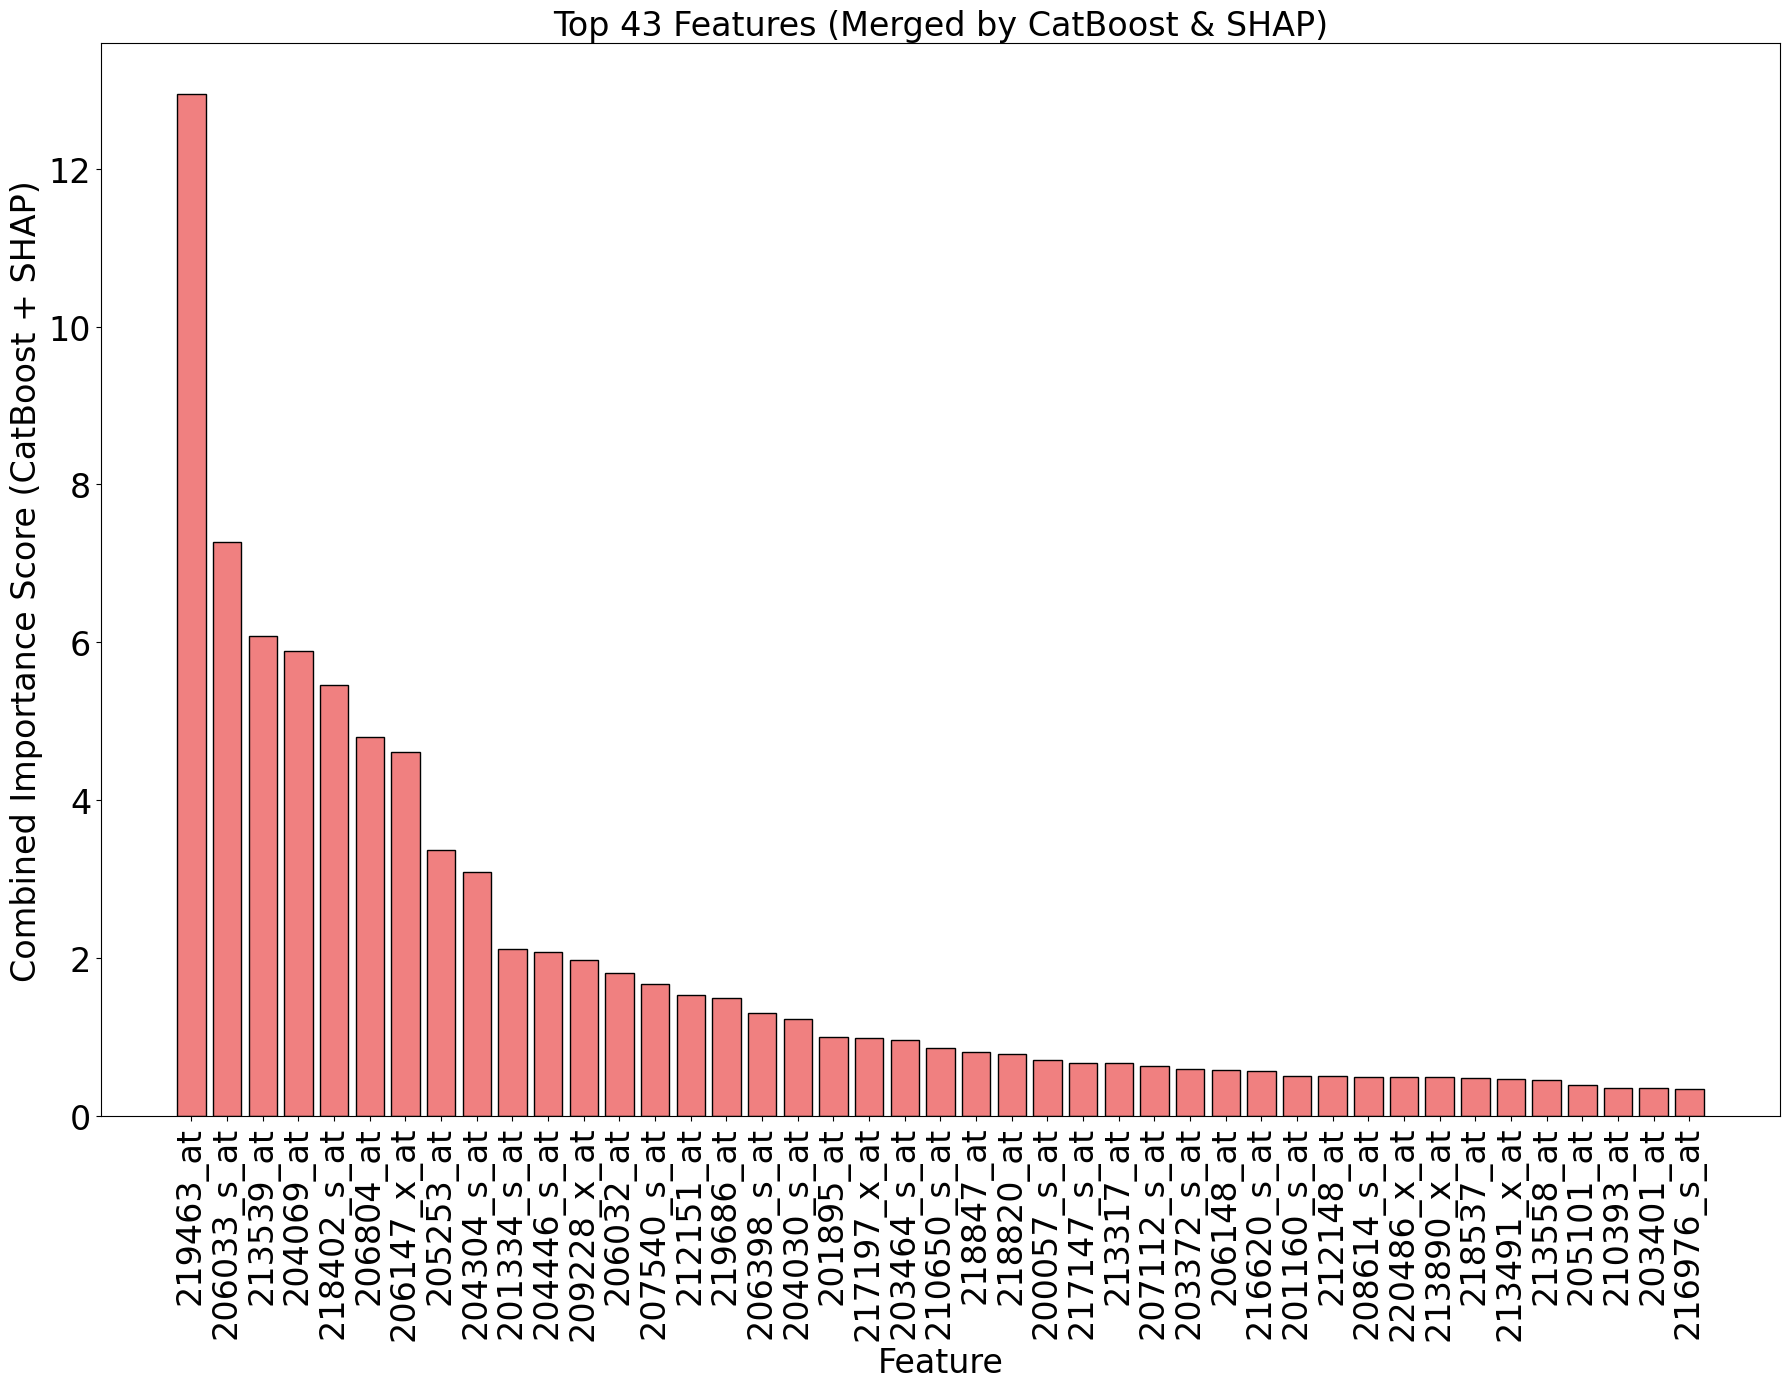

2025-07-09 10:43:05,118 - INFO - Training CNN Ensemble...
2025-07-09 10:43:05,218 - INFO - Fitting CNN Models...
2025-07-09 10:43:27,823 - INFO - CNN Ensemble trained in 22.60 seconds.
2025-07-09 10:43:27,824 - INFO - Predicting with CNN Models...
2025-07-09 10:43:28,216 - INFO - CNN Ensemble predicted in 0.39 seconds.
2025-07-09 10:43:28,217 - INFO - Calculating Evaluation Metrics...
2025-07-09 10:43:28,222 - INFO - Evaluation metrics: {'accuracy': 0.7931034482758621, 'precision': 0.826530612244898, 'recall': 0.8149659863945579, 'f1_score': 0.809024309024309, 'confusion_matrix': [[4, 1, 2, 0, 0, 0, 0], [0, 5, 1, 0, 0, 0, 0], [0, 0, 4, 0, 0, 1, 0], [0, 0, 0, 5, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0], [0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 2]]}


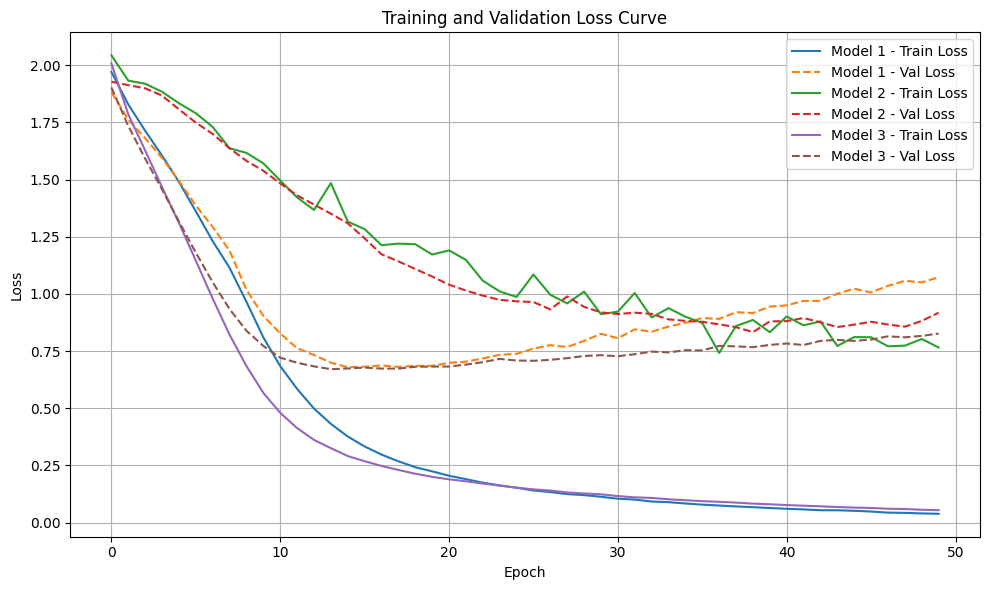

2025-07-09 10:43:28,375 - INFO - Cleaning up models...
2025-07-09 10:43:30,361 - INFO - Fold 2/10
2025-07-09 10:43:30,918 - INFO - Starting dimensionality reduction...


0:	learn: 1.7201076	total: 459ms	remaining: 1m 31s
1:	learn: 1.5525296	total: 701ms	remaining: 1m 9s
2:	learn: 1.4204561	total: 948ms	remaining: 1m 2s
3:	learn: 1.3083357	total: 1.2s	remaining: 58.8s
4:	learn: 1.2109321	total: 1.46s	remaining: 56.8s
5:	learn: 1.1236821	total: 1.69s	remaining: 54.7s
6:	learn: 1.0352192	total: 1.96s	remaining: 54.1s
7:	learn: 0.9598363	total: 2.25s	remaining: 54.1s
8:	learn: 0.9074388	total: 2.57s	remaining: 54.5s
9:	learn: 0.8600789	total: 2.85s	remaining: 54.3s
10:	learn: 0.8137183	total: 3.12s	remaining: 53.6s
11:	learn: 0.7739283	total: 3.41s	remaining: 53.4s
12:	learn: 0.7338207	total: 3.68s	remaining: 53s
13:	learn: 0.6945399	total: 3.96s	remaining: 52.6s
14:	learn: 0.6617368	total: 4.23s	remaining: 52.2s
15:	learn: 0.6317626	total: 4.52s	remaining: 52s
16:	learn: 0.6052917	total: 4.81s	remaining: 51.8s
17:	learn: 0.5803732	total: 5.11s	remaining: 51.7s
18:	learn: 0.5529216	total: 5.42s	remaining: 51.6s
19:	learn: 0.5315613	total: 5.7s	remaining: 5

2025-07-09 10:44:29,764 - INFO - Calculating SHAP values...
2025-07-09 10:44:39,613 - INFO - SHAP values: Multiclass (3D Array), Shape: (253, 22283, 7)
2025-07-09 10:44:39,916 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 10:44:39,918 - INFO - Shape of shap_importance: (22283,)
2025-07-09 10:44:39,919 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 10:44:39,920 - INFO - Shape of X.columns: (22283,)
2025-07-09 10:44:39,921 - INFO - Length comparison: len(X.columns)=22283, len(shap_importance)=22283
2025-07-09 10:44:39,925 - INFO - SHAP values calculated.
2025-07-09 10:44:39,929 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_1.pkl
2025-07-09 10:44:39,930 - INFO - Dimensionality reduction completed in 69.01 seconds.


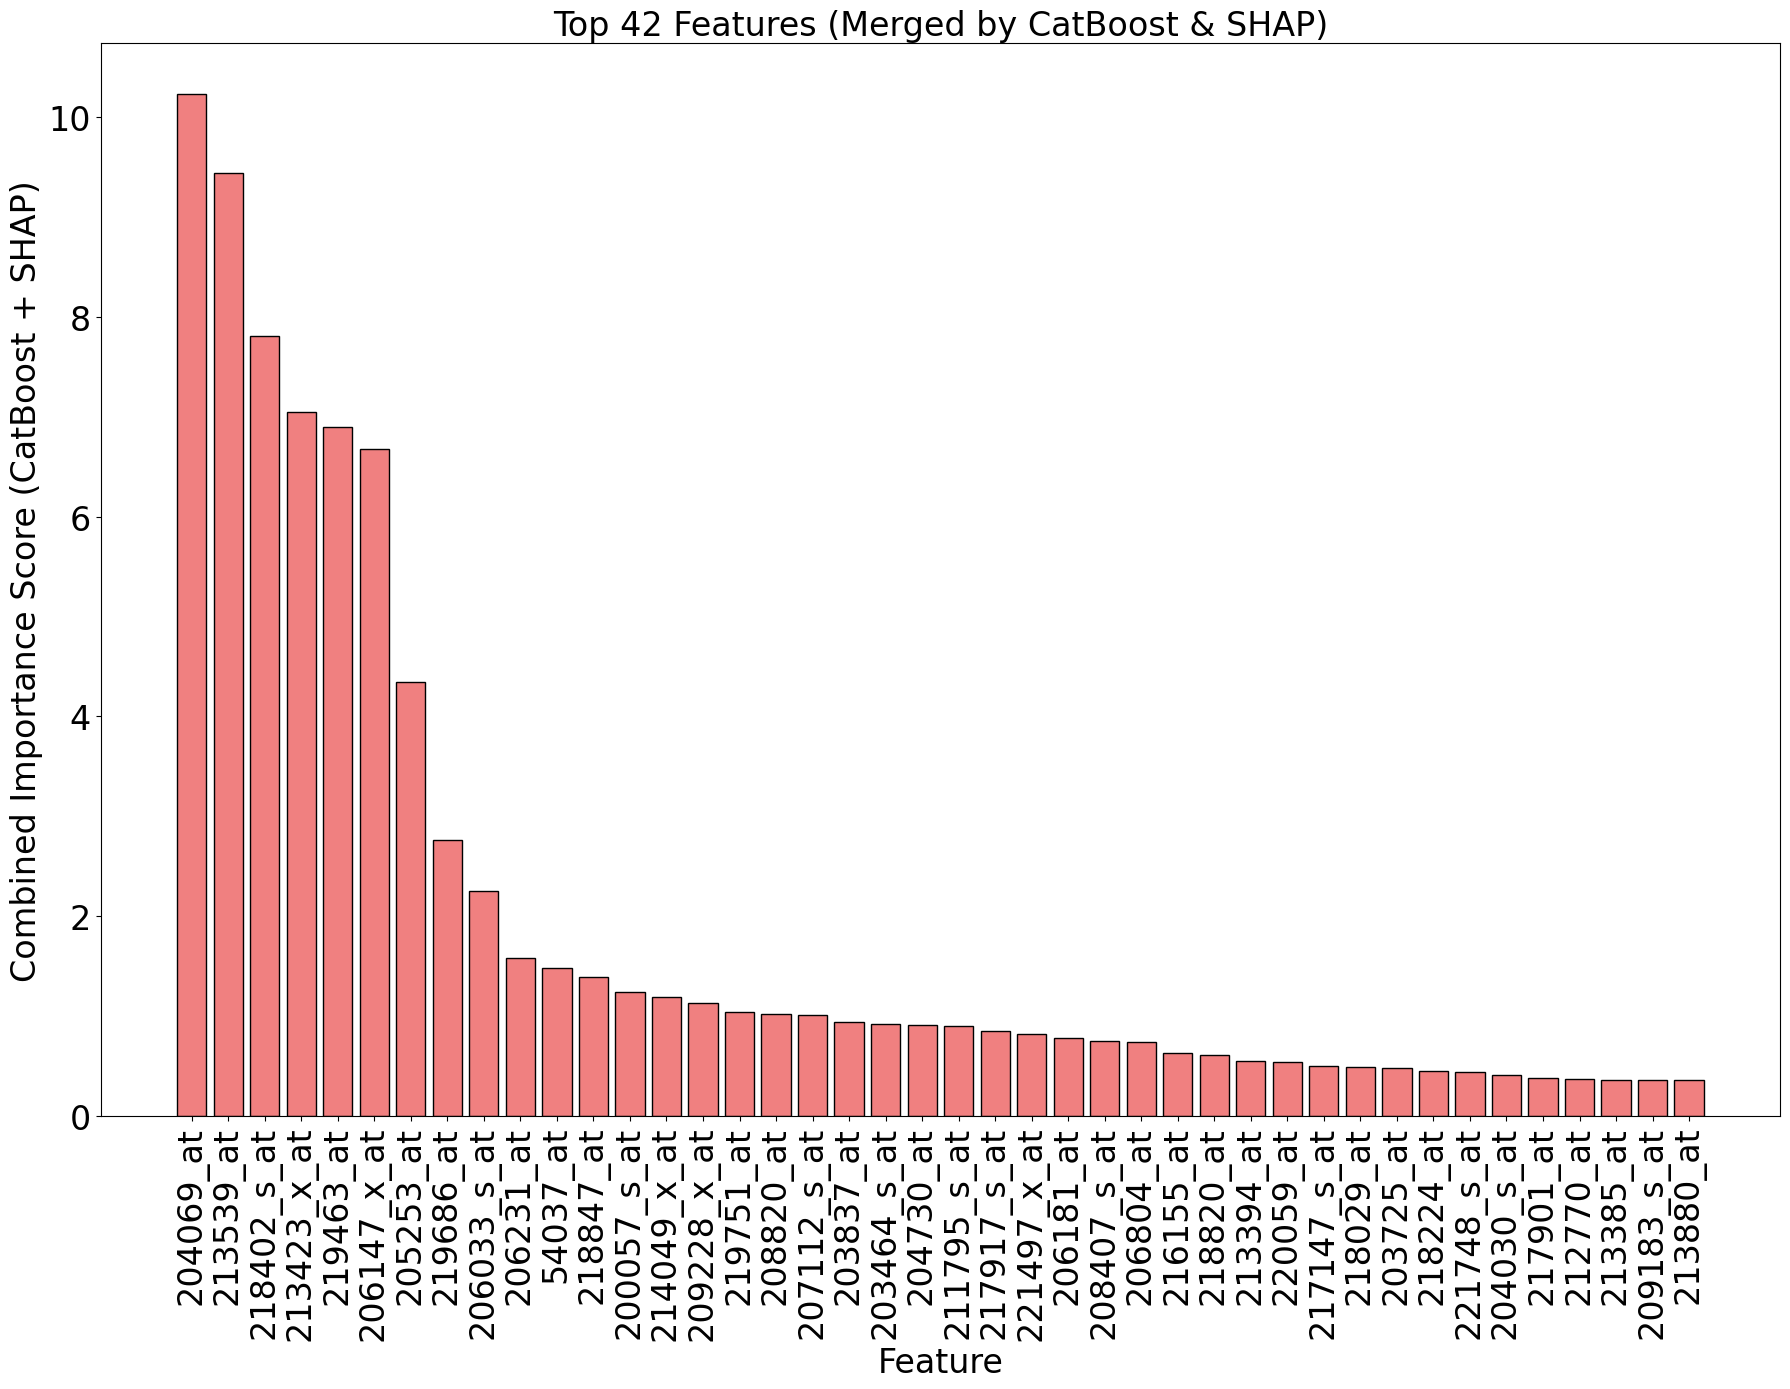

2025-07-09 10:44:40,677 - INFO - Training CNN Ensemble...
2025-07-09 10:44:40,827 - INFO - Fitting CNN Models...
2025-07-09 10:45:04,605 - INFO - CNN Ensemble trained in 23.78 seconds.
2025-07-09 10:45:04,606 - INFO - Predicting with CNN Models...
2025-07-09 10:45:05,041 - INFO - CNN Ensemble predicted in 0.43 seconds.
2025-07-09 10:45:05,042 - INFO - Calculating Evaluation Metrics...
2025-07-09 10:45:05,049 - INFO - Evaluation metrics: {'accuracy': 0.8928571428571429, 'precision': 0.8015873015873015, 'recall': 0.8285714285714285, 'f1_score': 0.8104256854256854, 'confusion_matrix': [[7, 0, 0, 0, 0, 0, 0], [0, 6, 0, 0, 0, 0, 0], [0, 0, 4, 1, 0, 0, 0], [0, 0, 0, 5, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0], [2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1]]}


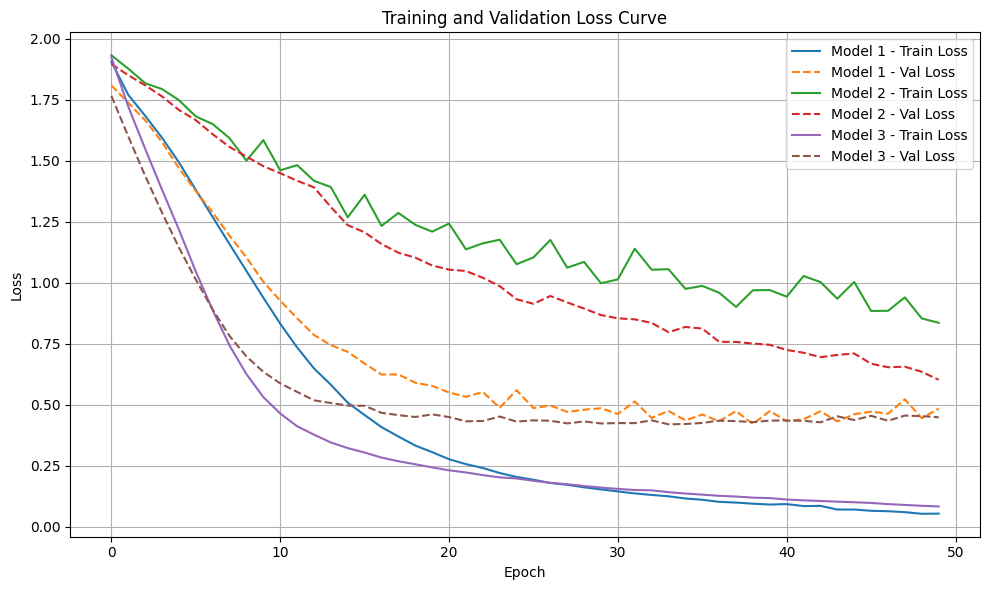

2025-07-09 10:45:05,278 - INFO - Cleaning up models...
2025-07-09 10:45:06,958 - INFO - Fold 3/10
2025-07-09 10:45:07,459 - INFO - Starting dimensionality reduction...


0:	learn: 1.7233877	total: 353ms	remaining: 1m 10s
1:	learn: 1.5457969	total: 588ms	remaining: 58.2s
2:	learn: 1.4036178	total: 812ms	remaining: 53.3s
3:	learn: 1.2862578	total: 1.05s	remaining: 51.5s
4:	learn: 1.1868325	total: 1.3s	remaining: 50.7s
5:	learn: 1.1044415	total: 1.56s	remaining: 50.3s
6:	learn: 1.0355707	total: 1.79s	remaining: 49.3s
7:	learn: 0.9745734	total: 2.02s	remaining: 48.6s
8:	learn: 0.9204624	total: 2.28s	remaining: 48.4s
9:	learn: 0.8667347	total: 2.52s	remaining: 47.8s
10:	learn: 0.8231593	total: 2.79s	remaining: 48s
11:	learn: 0.7816226	total: 3.04s	remaining: 47.7s
12:	learn: 0.7420705	total: 3.3s	remaining: 47.4s
13:	learn: 0.7099053	total: 3.53s	remaining: 46.9s
14:	learn: 0.6790095	total: 3.76s	remaining: 46.4s
15:	learn: 0.6476627	total: 4s	remaining: 46.1s
16:	learn: 0.6242422	total: 4.25s	remaining: 45.7s
17:	learn: 0.5985645	total: 4.5s	remaining: 45.5s
18:	learn: 0.5789235	total: 4.76s	remaining: 45.3s
19:	learn: 0.5607753	total: 4.99s	remaining: 44.

2025-07-09 10:45:59,509 - INFO - Calculating SHAP values...
2025-07-09 10:46:09,698 - INFO - SHAP values: Multiclass (3D Array), Shape: (253, 22283, 7)
2025-07-09 10:46:10,057 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 10:46:10,059 - INFO - Shape of shap_importance: (22283,)
2025-07-09 10:46:10,060 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 10:46:10,061 - INFO - Shape of X.columns: (22283,)
2025-07-09 10:46:10,061 - INFO - Length comparison: len(X.columns)=22283, len(shap_importance)=22283
2025-07-09 10:46:10,068 - INFO - SHAP values calculated.
2025-07-09 10:46:10,073 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_2.pkl
2025-07-09 10:46:10,075 - INFO - Dimensionality reduction completed in 62.62 seconds.


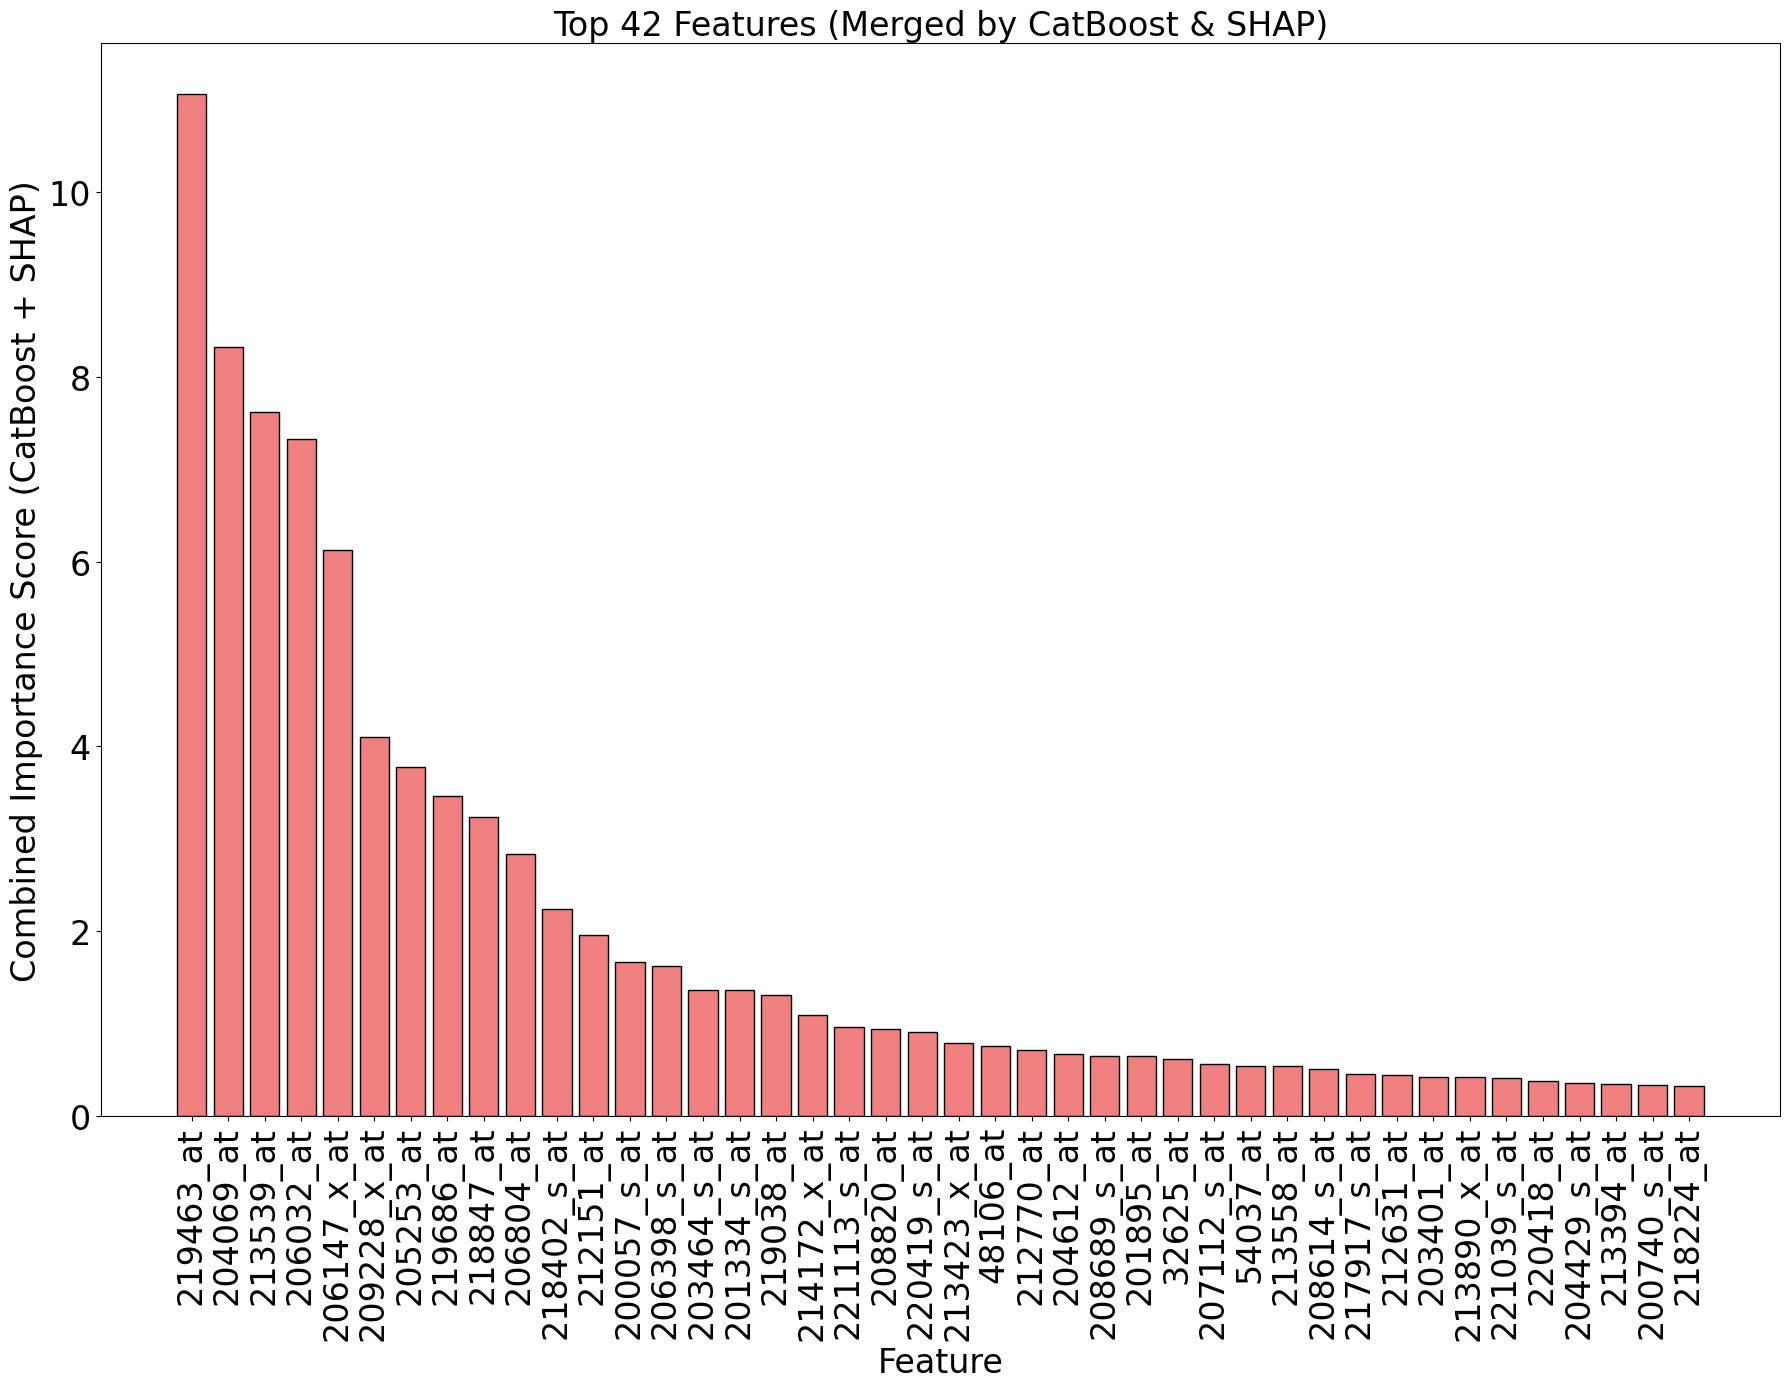

2025-07-09 10:46:12,616 - INFO - Training CNN Ensemble...
2025-07-09 10:46:12,801 - INFO - Fitting CNN Models...
2025-07-09 10:46:45,228 - INFO - CNN Ensemble trained in 32.43 seconds.
2025-07-09 10:46:45,229 - INFO - Predicting with CNN Models...
2025-07-09 10:46:45,580 - INFO - CNN Ensemble predicted in 0.35 seconds.
2025-07-09 10:46:45,580 - INFO - Calculating Evaluation Metrics...
2025-07-09 10:46:45,585 - INFO - Evaluation metrics: {'accuracy': 0.8571428571428571, 'precision': 0.9119047619047619, 'recall': 0.8673469387755102, 'f1_score': 0.8713667285095857, 'confusion_matrix': [[4, 2, 1, 0, 0, 0, 0], [0, 6, 0, 0, 0, 0, 0], [0, 0, 5, 0, 0, 0, 0], [0, 0, 0, 5, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0], [1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1]]}


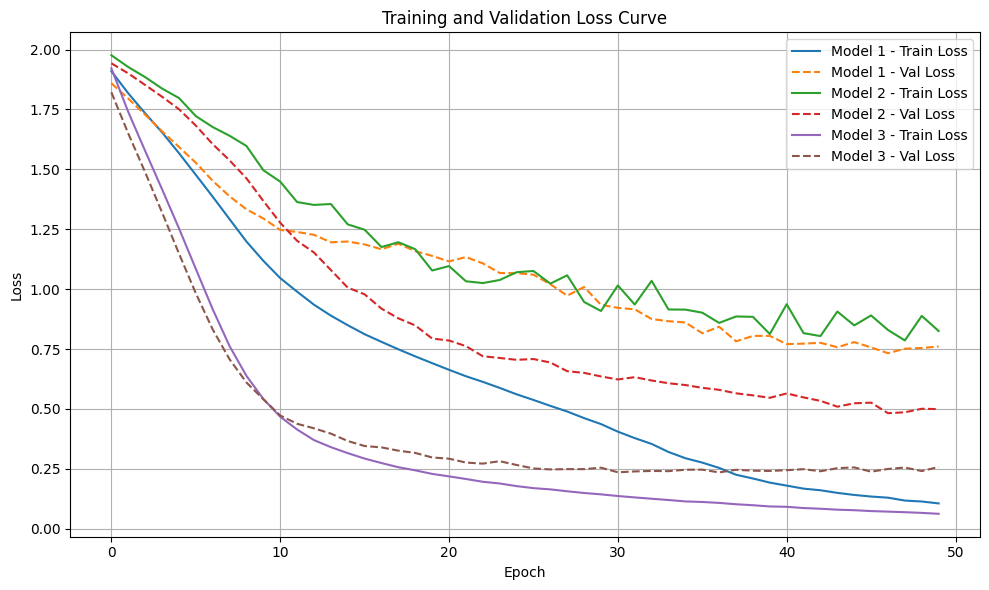

2025-07-09 10:46:45,757 - INFO - Cleaning up models...
2025-07-09 10:46:47,509 - INFO - Fold 4/10
2025-07-09 10:46:48,057 - INFO - Starting dimensionality reduction...


0:	learn: 1.7314012	total: 364ms	remaining: 1m 12s
1:	learn: 1.5568445	total: 620ms	remaining: 1m 1s
2:	learn: 1.4283575	total: 885ms	remaining: 58.1s
3:	learn: 1.3178033	total: 1.13s	remaining: 55.1s
4:	learn: 1.2253852	total: 1.38s	remaining: 53.7s
5:	learn: 1.1308296	total: 1.6s	remaining: 51.7s
6:	learn: 1.0592864	total: 1.83s	remaining: 50.5s
7:	learn: 0.9879454	total: 2.06s	remaining: 49.5s
8:	learn: 0.9330354	total: 2.33s	remaining: 49.4s
9:	learn: 0.8826196	total: 2.56s	remaining: 48.7s
10:	learn: 0.8359876	total: 2.81s	remaining: 48.2s
11:	learn: 0.7901867	total: 3.06s	remaining: 48s
12:	learn: 0.7530598	total: 3.31s	remaining: 47.7s
13:	learn: 0.7170579	total: 3.54s	remaining: 47.1s
14:	learn: 0.6857699	total: 3.78s	remaining: 46.6s
15:	learn: 0.6546737	total: 4.01s	remaining: 46.1s
16:	learn: 0.6254014	total: 4.28s	remaining: 46.1s
17:	learn: 0.5937242	total: 4.54s	remaining: 45.9s
18:	learn: 0.5687933	total: 4.78s	remaining: 45.5s
19:	learn: 0.5452666	total: 5.01s	remaining

2025-07-09 10:47:42,254 - INFO - Calculating SHAP values...


199:	learn: 0.0561944	total: 51.7s	remaining: 0us


2025-07-09 10:47:46,688 - INFO - SHAP values: Multiclass (3D Array), Shape: (253, 22283, 7)
2025-07-09 10:47:46,886 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 10:47:46,887 - INFO - Shape of shap_importance: (22283,)
2025-07-09 10:47:46,888 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 10:47:46,888 - INFO - Shape of X.columns: (22283,)
2025-07-09 10:47:46,889 - INFO - Length comparison: len(X.columns)=22283, len(shap_importance)=22283
2025-07-09 10:47:46,893 - INFO - SHAP values calculated.
2025-07-09 10:47:46,898 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_3.pkl
2025-07-09 10:47:46,899 - INFO - Dimensionality reduction completed in 58.84 seconds.


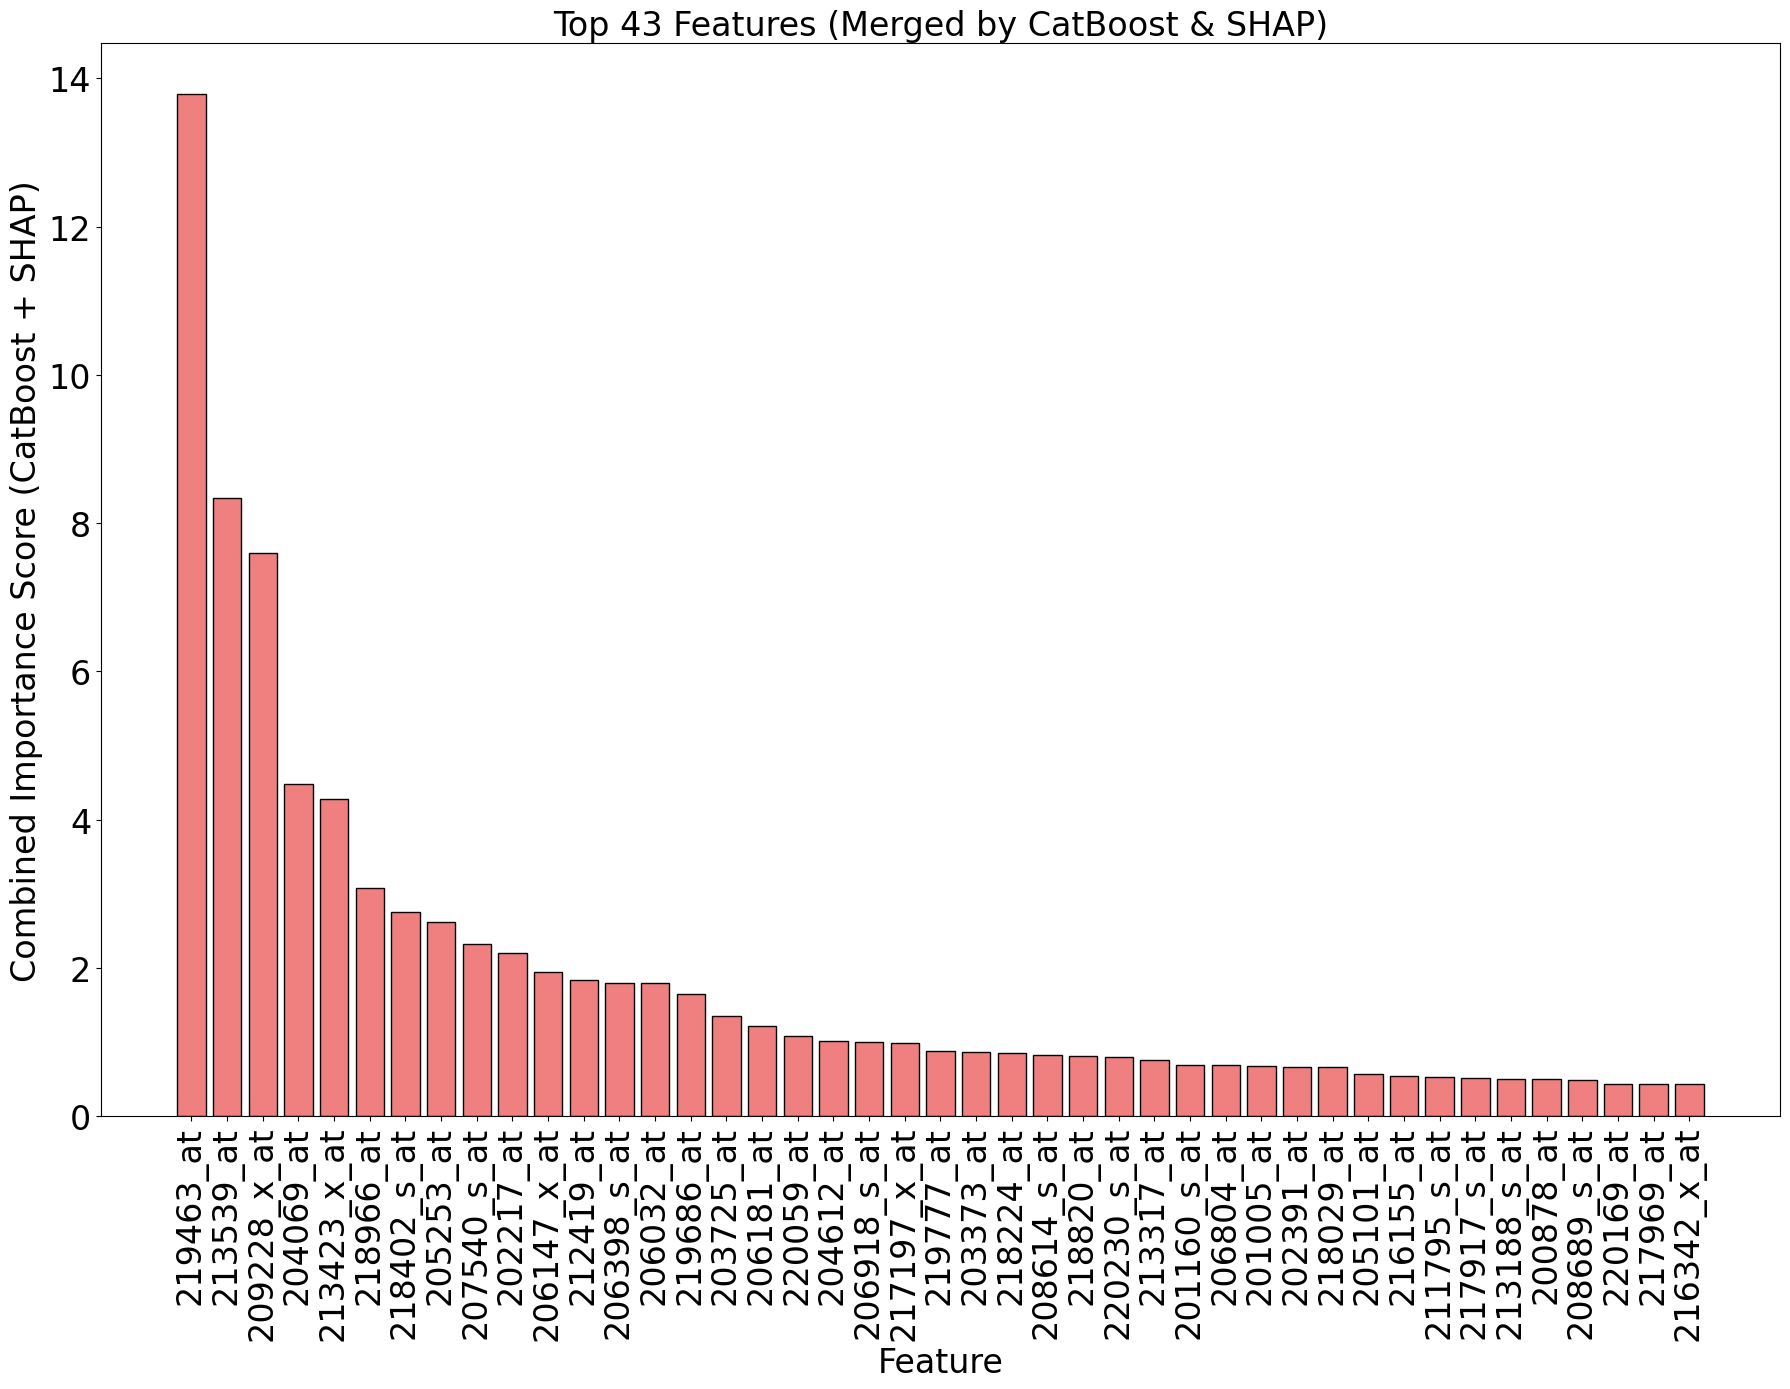

2025-07-09 10:47:47,464 - INFO - Training CNN Ensemble...
2025-07-09 10:47:47,556 - INFO - Fitting CNN Models...
2025-07-09 10:48:21,185 - INFO - CNN Ensemble trained in 33.63 seconds.
2025-07-09 10:48:21,185 - INFO - Predicting with CNN Models...
2025-07-09 10:48:21,538 - INFO - CNN Ensemble predicted in 0.35 seconds.
2025-07-09 10:48:21,540 - INFO - Calculating Evaluation Metrics...
2025-07-09 10:48:21,544 - INFO - Evaluation metrics: {'accuracy': 0.8928571428571429, 'precision': 0.753968253968254, 'recall': 0.8392857142857143, 'f1_score': 0.7843137254901961, 'confusion_matrix': [[7, 0, 0, 0, 0, 0, 1], [0, 5, 0, 0, 0, 0, 0], [0, 0, 5, 0, 0, 0, 0], [0, 0, 0, 5, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0], [2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1]]}


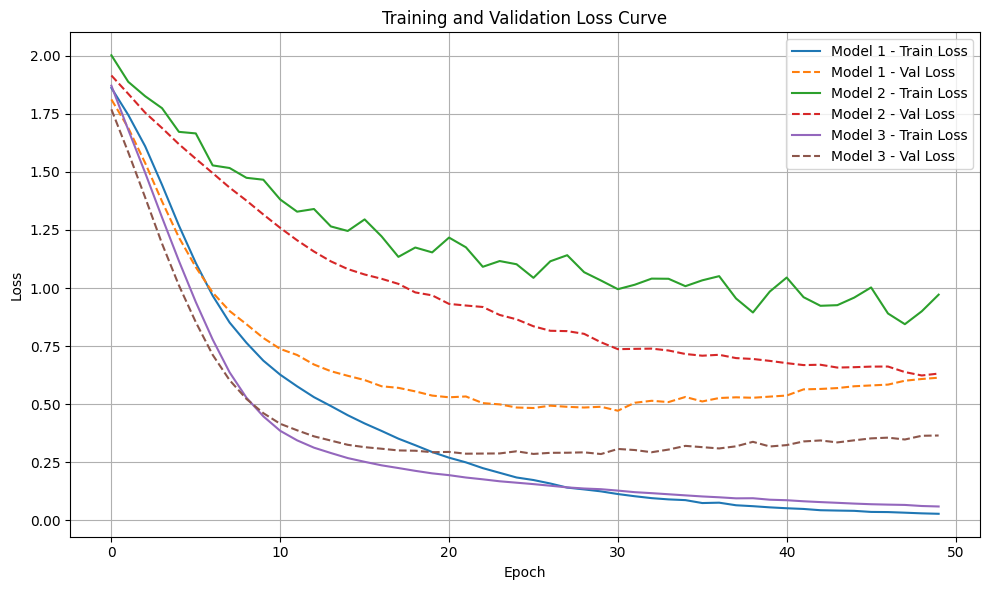

2025-07-09 10:48:21,713 - INFO - Cleaning up models...
2025-07-09 10:48:23,460 - INFO - Fold 5/10
2025-07-09 10:48:24,018 - INFO - Starting dimensionality reduction...


0:	learn: 1.7303245	total: 362ms	remaining: 1m 12s
1:	learn: 1.5492322	total: 617ms	remaining: 1m 1s
2:	learn: 1.4052667	total: 851ms	remaining: 55.9s
3:	learn: 1.2953178	total: 1.11s	remaining: 54.3s
4:	learn: 1.1868771	total: 1.37s	remaining: 53.3s
5:	learn: 1.1065640	total: 1.62s	remaining: 52.3s
6:	learn: 1.0378789	total: 1.85s	remaining: 51.2s
7:	learn: 0.9768858	total: 2.13s	remaining: 51s
8:	learn: 0.9235998	total: 2.39s	remaining: 50.8s
9:	learn: 0.8693205	total: 2.65s	remaining: 50.3s
10:	learn: 0.8156798	total: 2.88s	remaining: 49.6s
11:	learn: 0.7782945	total: 3.17s	remaining: 49.7s
12:	learn: 0.7402341	total: 3.44s	remaining: 49.5s
13:	learn: 0.7085002	total: 3.74s	remaining: 49.7s
14:	learn: 0.6757775	total: 4.02s	remaining: 49.6s
15:	learn: 0.6433907	total: 4.31s	remaining: 49.6s
16:	learn: 0.6139797	total: 4.59s	remaining: 49.4s
17:	learn: 0.5857014	total: 4.86s	remaining: 49.2s
18:	learn: 0.5591144	total: 5.15s	remaining: 49.1s
19:	learn: 0.5380987	total: 5.43s	remainin

2025-07-09 10:49:20,852 - INFO - Calculating SHAP values...
2025-07-09 10:49:31,537 - INFO - SHAP values: Multiclass (3D Array), Shape: (253, 22283, 7)
2025-07-09 10:49:31,846 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 10:49:31,847 - INFO - Shape of shap_importance: (22283,)
2025-07-09 10:49:31,848 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 10:49:31,850 - INFO - Shape of X.columns: (22283,)
2025-07-09 10:49:31,851 - INFO - Length comparison: len(X.columns)=22283, len(shap_importance)=22283
2025-07-09 10:49:31,862 - INFO - SHAP values calculated.
2025-07-09 10:49:31,871 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_4.pkl
2025-07-09 10:49:31,872 - INFO - Dimensionality reduction completed in 67.85 seconds.


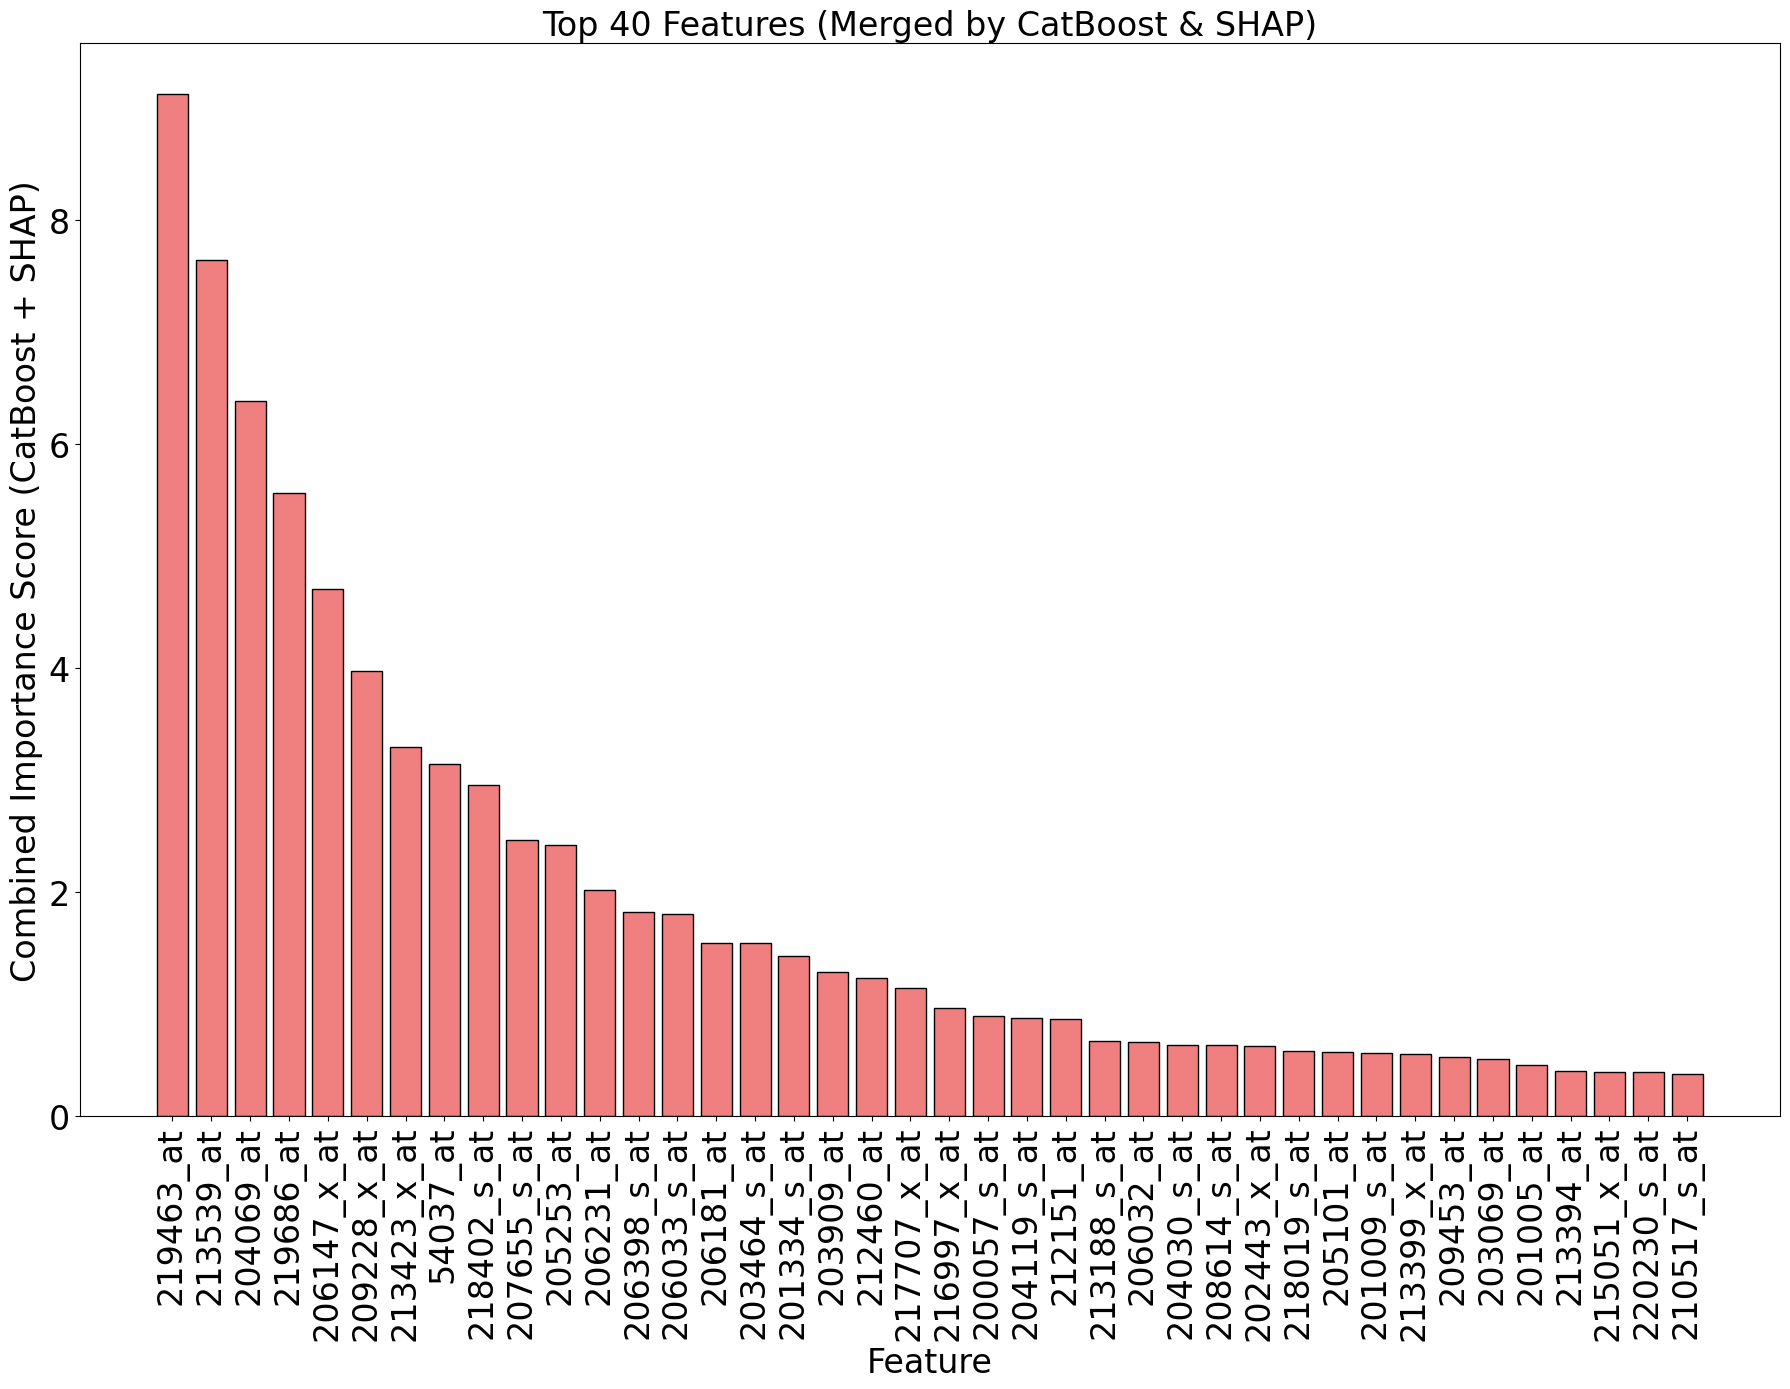

2025-07-09 10:49:33,032 - INFO - Training CNN Ensemble...
2025-07-09 10:49:33,263 - INFO - Fitting CNN Models...
2025-07-09 10:50:33,568 - INFO - CNN Ensemble trained in 60.31 seconds.
2025-07-09 10:50:33,571 - INFO - Predicting with CNN Models...
2025-07-09 10:50:34,926 - INFO - CNN Ensemble predicted in 1.35 seconds.
2025-07-09 10:50:34,928 - INFO - Calculating Evaluation Metrics...
2025-07-09 10:50:34,941 - INFO - Evaluation metrics: {'accuracy': 0.8928571428571429, 'precision': 0.8181818181818182, 'recall': 0.7999999999999999, 'f1_score': 0.7988721804511278, 'confusion_matrix': [[8, 0, 0, 0, 0, 0, 0], [0, 5, 0, 0, 0, 0, 0], [2, 0, 3, 0, 0, 0, 0], [0, 0, 0, 5, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0], [1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2]]}


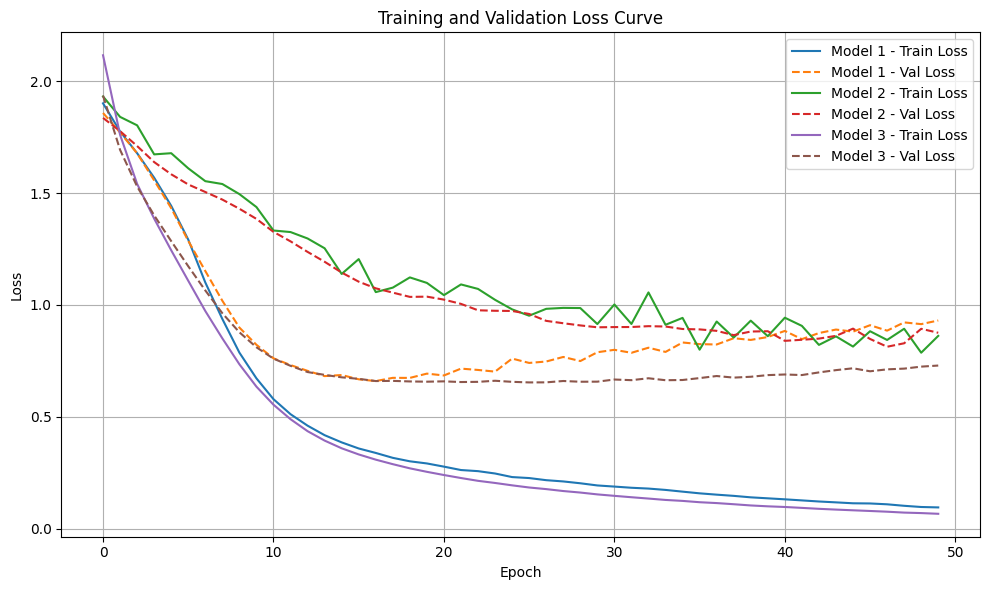

2025-07-09 10:50:35,344 - INFO - Cleaning up models...
2025-07-09 10:50:37,739 - INFO - Fold 6/10
2025-07-09 10:50:39,475 - INFO - Starting dimensionality reduction...


0:	learn: 1.7198146	total: 579ms	remaining: 1m 55s
1:	learn: 1.5478189	total: 859ms	remaining: 1m 25s
2:	learn: 1.4162783	total: 1.14s	remaining: 1m 14s
3:	learn: 1.3057729	total: 1.44s	remaining: 1m 10s
4:	learn: 1.1893113	total: 1.69s	remaining: 1m 5s
5:	learn: 1.1056221	total: 1.96s	remaining: 1m 3s
6:	learn: 1.0336095	total: 2.23s	remaining: 1m 1s
7:	learn: 0.9602811	total: 2.49s	remaining: 59.7s
8:	learn: 0.9058818	total: 2.75s	remaining: 58.4s
9:	learn: 0.8582703	total: 3.03s	remaining: 57.5s
10:	learn: 0.8134362	total: 3.31s	remaining: 56.9s
11:	learn: 0.7752940	total: 3.6s	remaining: 56.3s
12:	learn: 0.7368785	total: 3.88s	remaining: 55.8s
13:	learn: 0.7024330	total: 4.14s	remaining: 55s
14:	learn: 0.6711411	total: 4.4s	remaining: 54.3s
15:	learn: 0.6428811	total: 4.67s	remaining: 53.7s
16:	learn: 0.6087151	total: 4.96s	remaining: 53.4s
17:	learn: 0.5815406	total: 5.23s	remaining: 52.8s
18:	learn: 0.5552855	total: 5.53s	remaining: 52.6s
19:	learn: 0.5345903	total: 5.8s	remainin

2025-07-09 10:51:38,332 - INFO - Calculating SHAP values...
2025-07-09 10:51:42,725 - INFO - SHAP values: Multiclass (3D Array), Shape: (253, 22283, 7)
2025-07-09 10:51:42,948 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 10:51:42,949 - INFO - Shape of shap_importance: (22283,)
2025-07-09 10:51:42,949 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 10:51:42,951 - INFO - Shape of X.columns: (22283,)
2025-07-09 10:51:42,952 - INFO - Length comparison: len(X.columns)=22283, len(shap_importance)=22283
2025-07-09 10:51:42,955 - INFO - SHAP values calculated.
2025-07-09 10:51:42,961 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_5.pkl
2025-07-09 10:51:42,962 - INFO - Dimensionality reduction completed in 63.49 seconds.


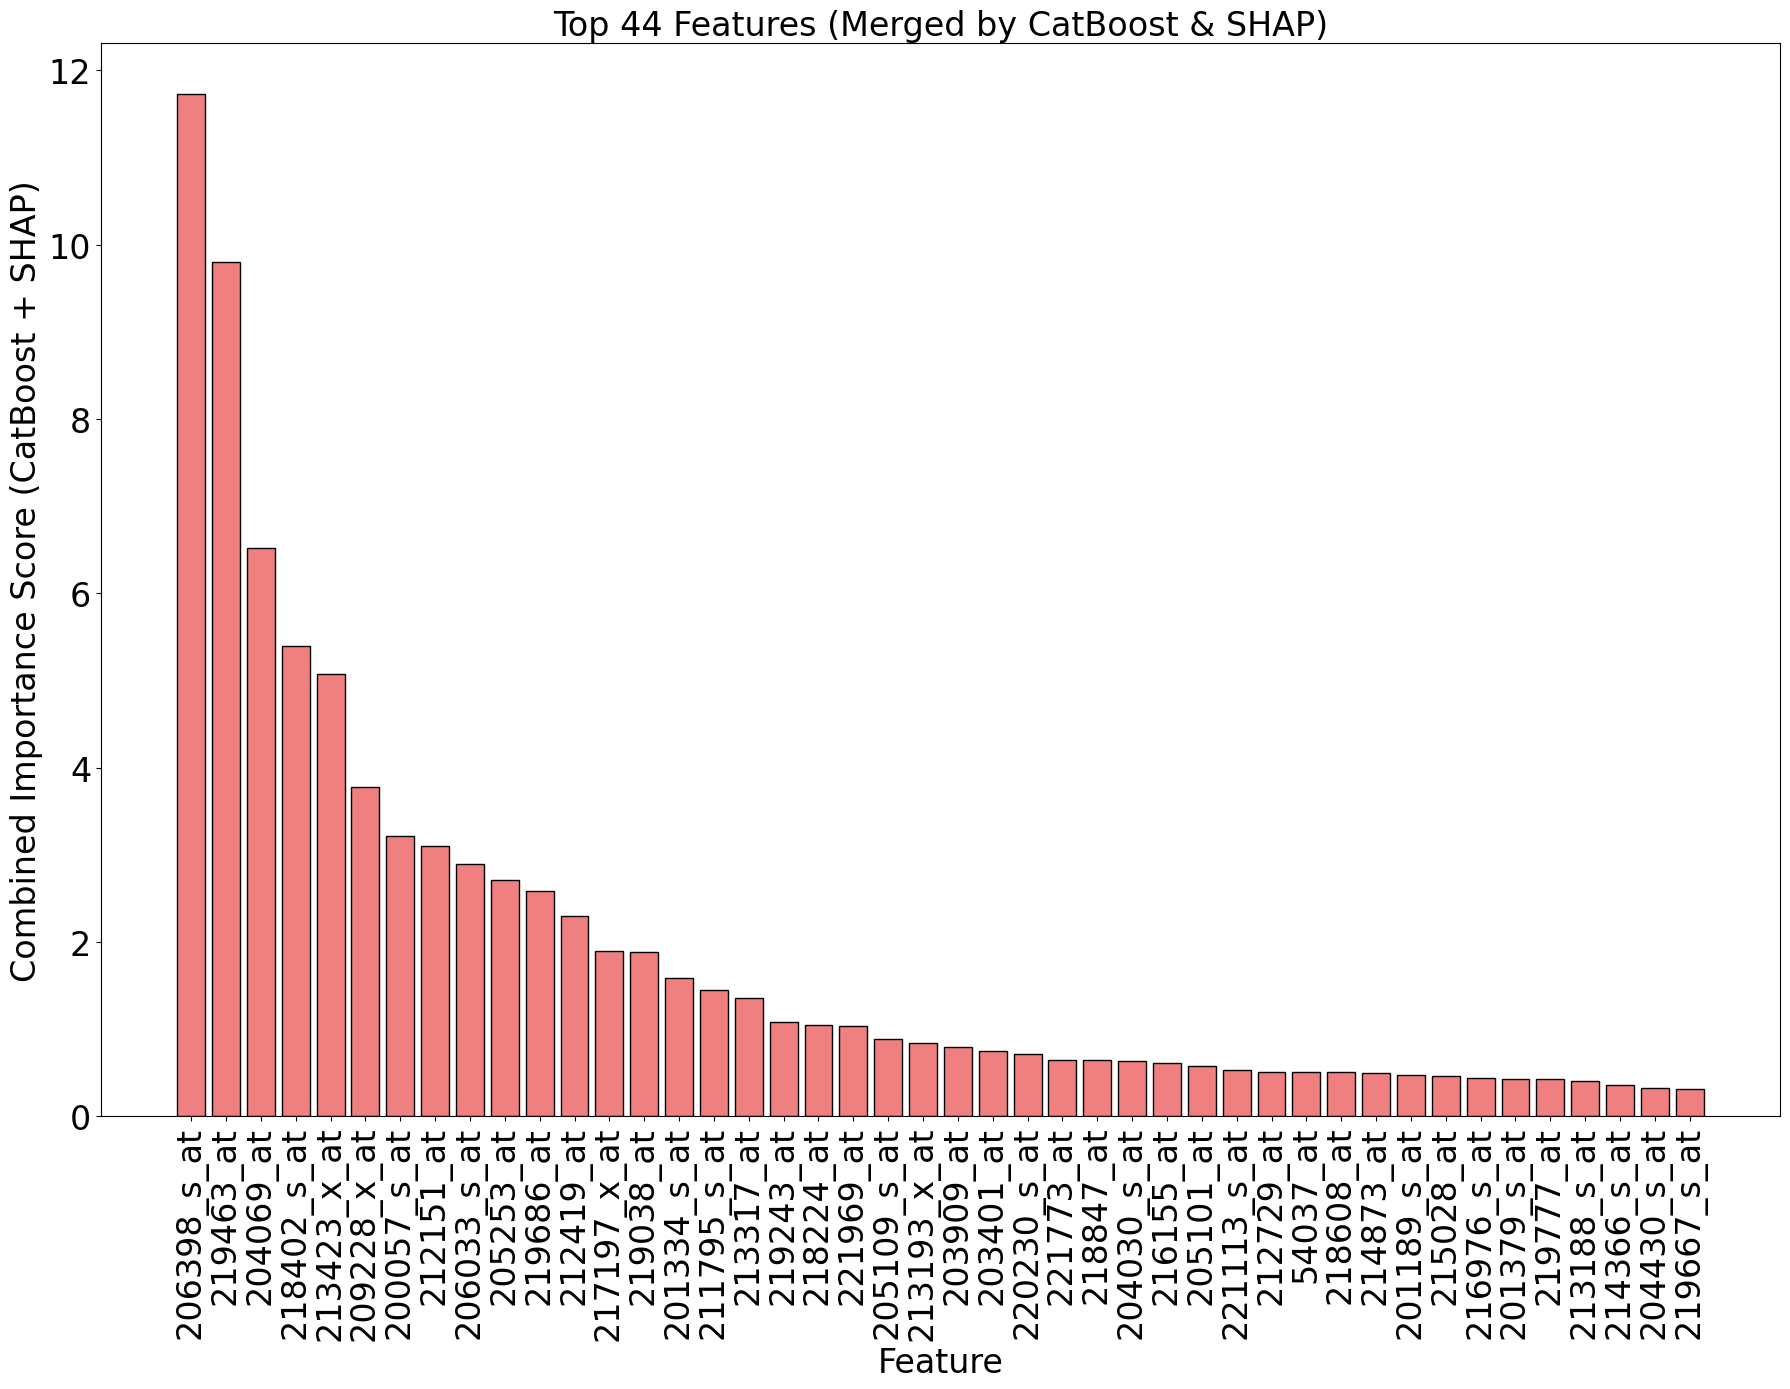

2025-07-09 10:51:43,493 - INFO - Training CNN Ensemble...
2025-07-09 10:51:43,582 - INFO - Fitting CNN Models...
2025-07-09 10:52:20,078 - INFO - CNN Ensemble trained in 36.50 seconds.
2025-07-09 10:52:20,081 - INFO - Predicting with CNN Models...
2025-07-09 10:52:21,118 - INFO - CNN Ensemble predicted in 1.04 seconds.
2025-07-09 10:52:21,120 - INFO - Calculating Evaluation Metrics...
2025-07-09 10:52:21,139 - INFO - Evaluation metrics: {'accuracy': 0.8571428571428571, 'precision': 0.8571428571428571, 'recall': 0.9178571428571428, 'f1_score': 0.8537573537573537, 'confusion_matrix': [[5, 1, 0, 1, 0, 1, 0], [0, 5, 0, 0, 0, 0, 0], [0, 0, 4, 0, 0, 1, 0], [0, 0, 0, 5, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 2]]}


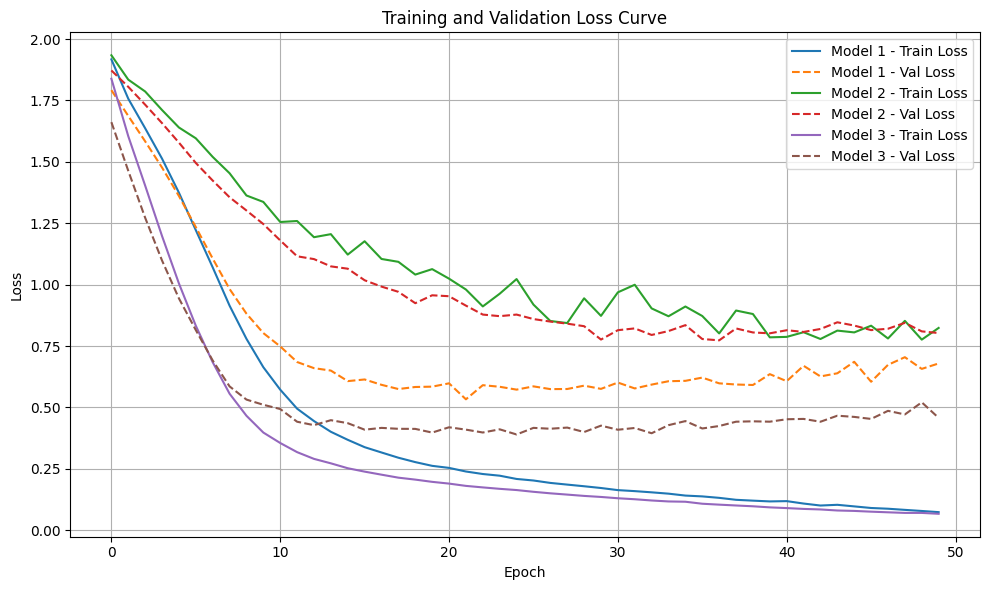

2025-07-09 10:52:21,602 - INFO - Cleaning up models...
2025-07-09 10:52:24,236 - INFO - Fold 7/10
2025-07-09 10:52:26,029 - INFO - Starting dimensionality reduction...


0:	learn: 1.7293285	total: 644ms	remaining: 2m 8s
1:	learn: 1.5606679	total: 924ms	remaining: 1m 31s
2:	learn: 1.4162976	total: 1.19s	remaining: 1m 17s
3:	learn: 1.3033438	total: 1.48s	remaining: 1m 12s
4:	learn: 1.1898730	total: 1.76s	remaining: 1m 8s
5:	learn: 1.1046997	total: 2.03s	remaining: 1m 5s
6:	learn: 1.0332511	total: 2.3s	remaining: 1m 3s
7:	learn: 0.9759938	total: 2.58s	remaining: 1m 1s
8:	learn: 0.9244627	total: 2.86s	remaining: 1m
9:	learn: 0.8728353	total: 3.13s	remaining: 59.4s
10:	learn: 0.8210792	total: 3.42s	remaining: 58.7s
11:	learn: 0.7822634	total: 3.71s	remaining: 58.1s
12:	learn: 0.7453279	total: 3.98s	remaining: 57.3s
13:	learn: 0.7083542	total: 4.27s	remaining: 56.7s
14:	learn: 0.6736106	total: 4.54s	remaining: 56.1s
15:	learn: 0.6454020	total: 4.84s	remaining: 55.7s
16:	learn: 0.6113033	total: 5.13s	remaining: 55.3s
17:	learn: 0.5858833	total: 5.42s	remaining: 54.8s
18:	learn: 0.5625798	total: 5.7s	remaining: 54.3s
19:	learn: 0.5443828	total: 5.98s	remaining

2025-07-09 10:53:26,210 - INFO - Calculating SHAP values...
2025-07-09 10:53:36,319 - INFO - SHAP values: Multiclass (3D Array), Shape: (253, 22283, 7)
2025-07-09 10:53:36,477 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 10:53:36,479 - INFO - Shape of shap_importance: (22283,)
2025-07-09 10:53:36,479 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 10:53:36,479 - INFO - Shape of X.columns: (22283,)
2025-07-09 10:53:36,479 - INFO - Length comparison: len(X.columns)=22283, len(shap_importance)=22283
2025-07-09 10:53:36,483 - INFO - SHAP values calculated.
2025-07-09 10:53:36,486 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_6.pkl
2025-07-09 10:53:36,487 - INFO - Dimensionality reduction completed in 70.46 seconds.


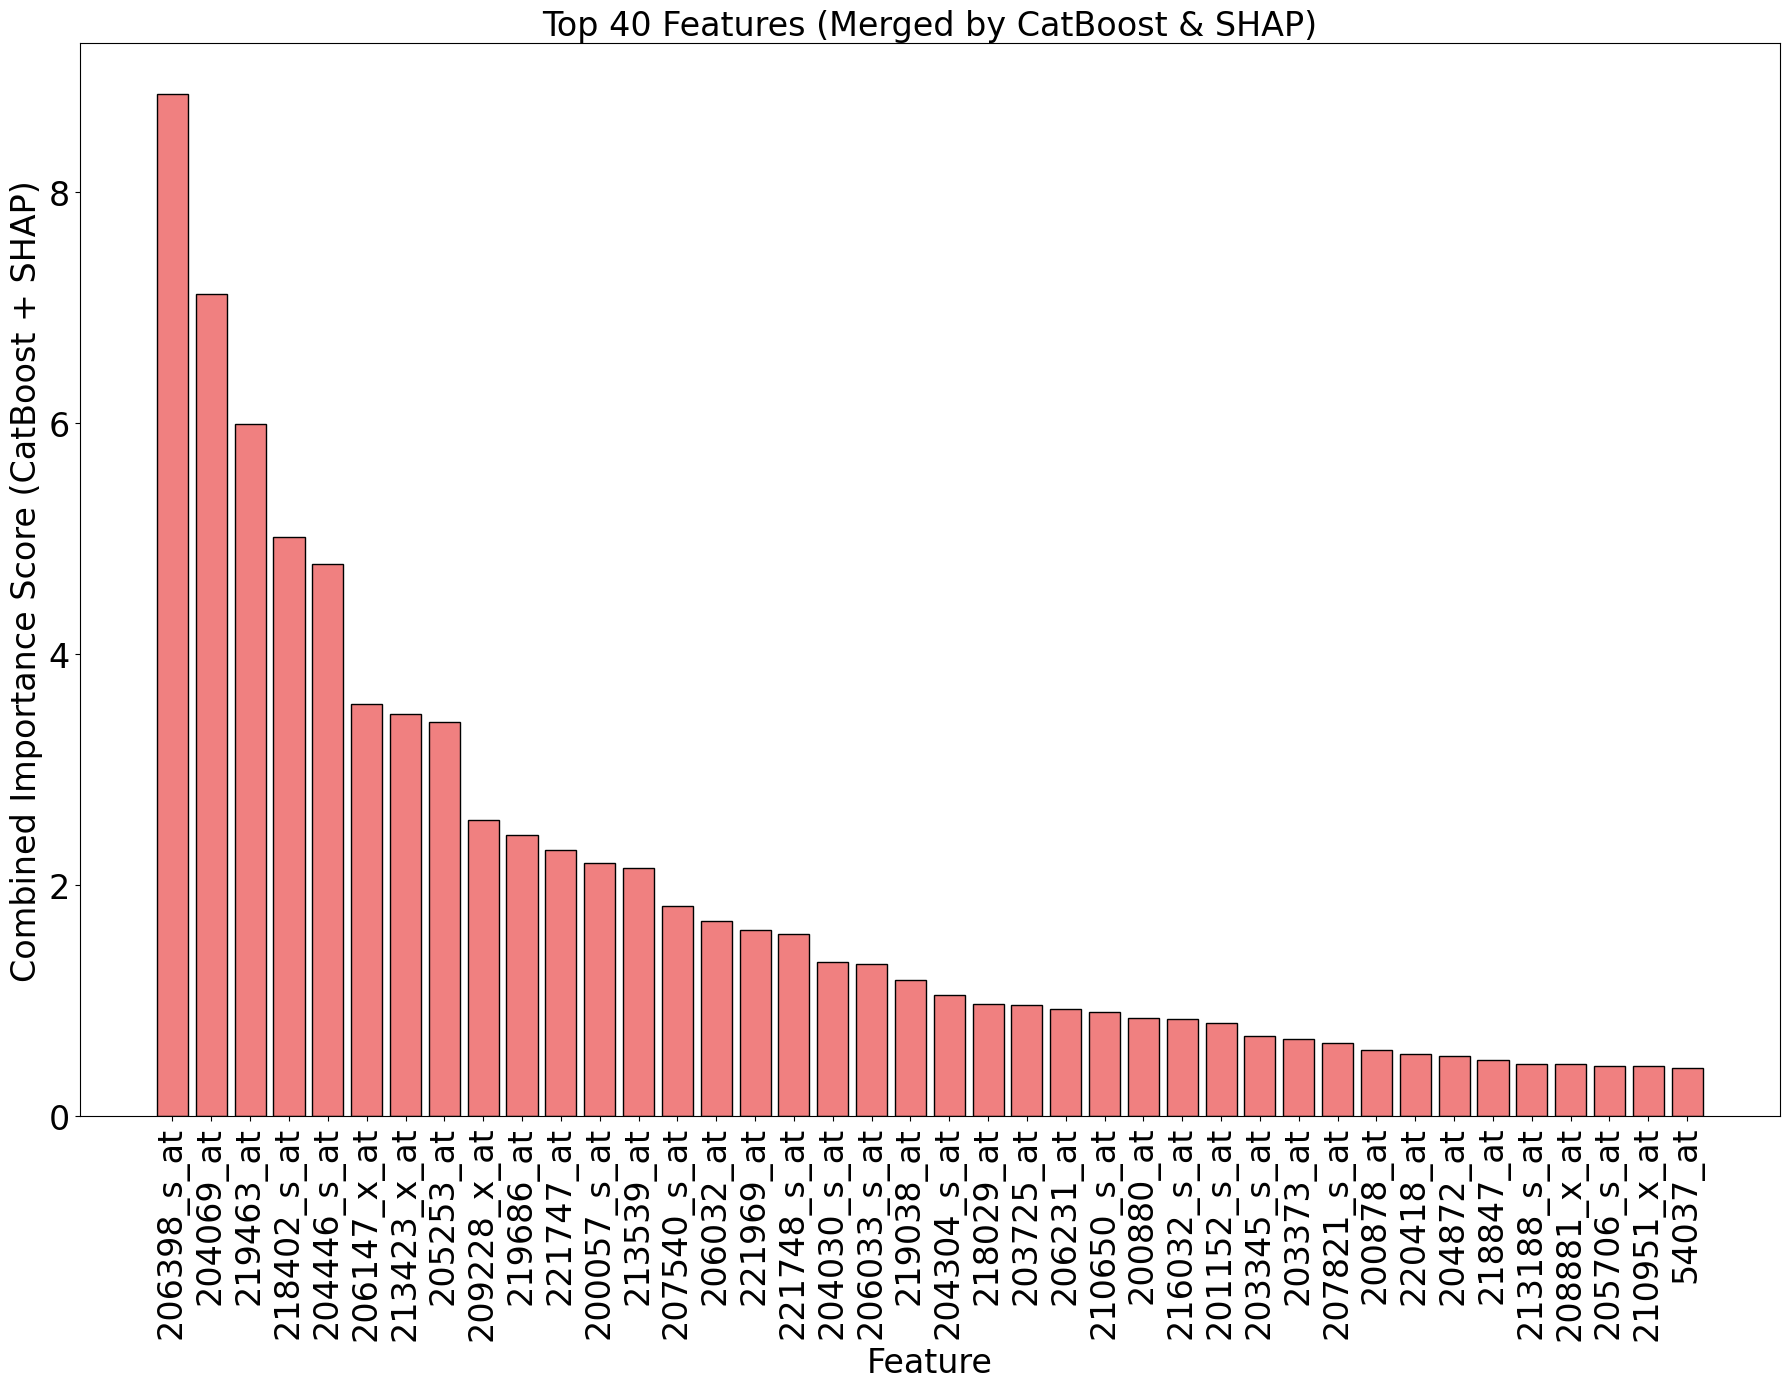

2025-07-09 10:53:37,211 - INFO - Training CNN Ensemble...
2025-07-09 10:53:37,417 - INFO - Fitting CNN Models...
2025-07-09 10:54:00,580 - INFO - CNN Ensemble trained in 23.16 seconds.
2025-07-09 10:54:00,581 - INFO - Predicting with CNN Models...
2025-07-09 10:54:00,942 - INFO - CNN Ensemble predicted in 0.36 seconds.
2025-07-09 10:54:00,943 - INFO - Calculating Evaluation Metrics...
2025-07-09 10:54:00,952 - INFO - Evaluation metrics: {'accuracy': 0.8571428571428571, 'precision': 0.7976190476190477, 'recall': 0.8214285714285714, 'f1_score': 0.8084415584415584, 'confusion_matrix': [[6, 1, 0, 0, 0, 1, 0], [0, 5, 0, 0, 0, 0, 0], [0, 0, 5, 0, 0, 0, 0], [0, 0, 0, 4, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0], [2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2]]}


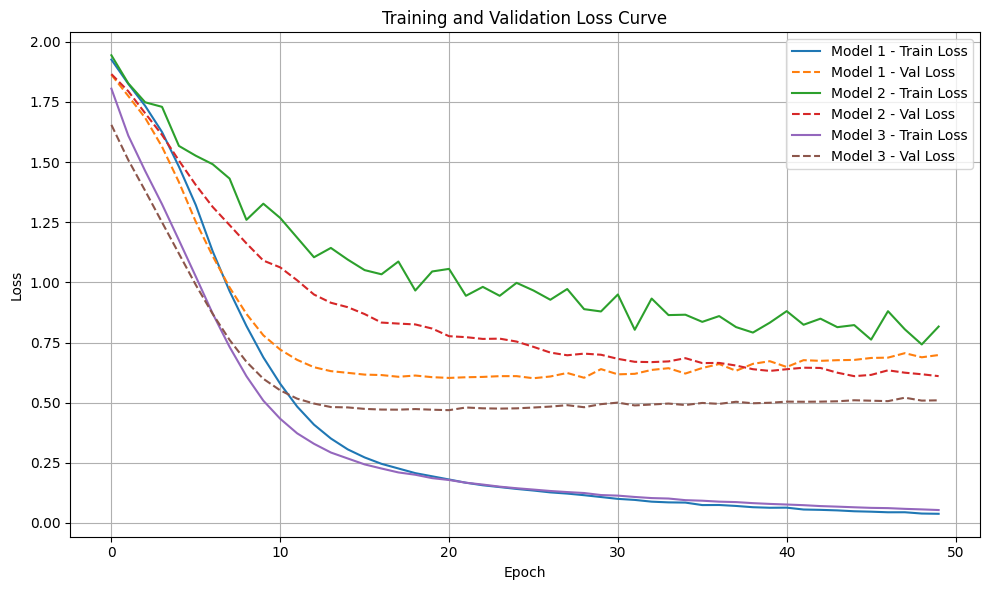

2025-07-09 10:54:01,132 - INFO - Cleaning up models...
2025-07-09 10:54:03,314 - INFO - Fold 8/10
2025-07-09 10:54:03,915 - INFO - Starting dimensionality reduction...


0:	learn: 1.7353975	total: 439ms	remaining: 1m 27s
1:	learn: 1.5662519	total: 683ms	remaining: 1m 7s
2:	learn: 1.4301203	total: 920ms	remaining: 1m
3:	learn: 1.3148468	total: 1.15s	remaining: 56.4s
4:	learn: 1.2186250	total: 1.4s	remaining: 54.8s
5:	learn: 1.1297936	total: 1.66s	remaining: 53.5s
6:	learn: 1.0521561	total: 1.92s	remaining: 53s
7:	learn: 0.9936421	total: 2.17s	remaining: 52.2s
8:	learn: 0.9379518	total: 2.41s	remaining: 51.2s
9:	learn: 0.8788327	total: 2.65s	remaining: 50.4s
10:	learn: 0.8253011	total: 2.88s	remaining: 49.4s
11:	learn: 0.7784436	total: 3.11s	remaining: 48.7s
12:	learn: 0.7393532	total: 3.34s	remaining: 48.1s
13:	learn: 0.7024224	total: 3.58s	remaining: 47.6s
14:	learn: 0.6723002	total: 3.82s	remaining: 47.1s
15:	learn: 0.6441907	total: 4.07s	remaining: 46.8s
16:	learn: 0.6180158	total: 4.32s	remaining: 46.5s
17:	learn: 0.5910348	total: 4.56s	remaining: 46.1s
18:	learn: 0.5689993	total: 4.82s	remaining: 45.9s
19:	learn: 0.5464322	total: 5.05s	remaining: 4

2025-07-09 10:55:00,535 - INFO - Calculating SHAP values...
2025-07-09 10:55:11,057 - INFO - SHAP values: Multiclass (3D Array), Shape: (253, 22283, 7)
2025-07-09 10:55:11,391 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 10:55:11,393 - INFO - Shape of shap_importance: (22283,)
2025-07-09 10:55:11,395 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 10:55:11,396 - INFO - Shape of X.columns: (22283,)
2025-07-09 10:55:11,398 - INFO - Length comparison: len(X.columns)=22283, len(shap_importance)=22283
2025-07-09 10:55:11,403 - INFO - SHAP values calculated.
2025-07-09 10:55:11,412 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_7.pkl
2025-07-09 10:55:11,413 - INFO - Dimensionality reduction completed in 67.50 seconds.


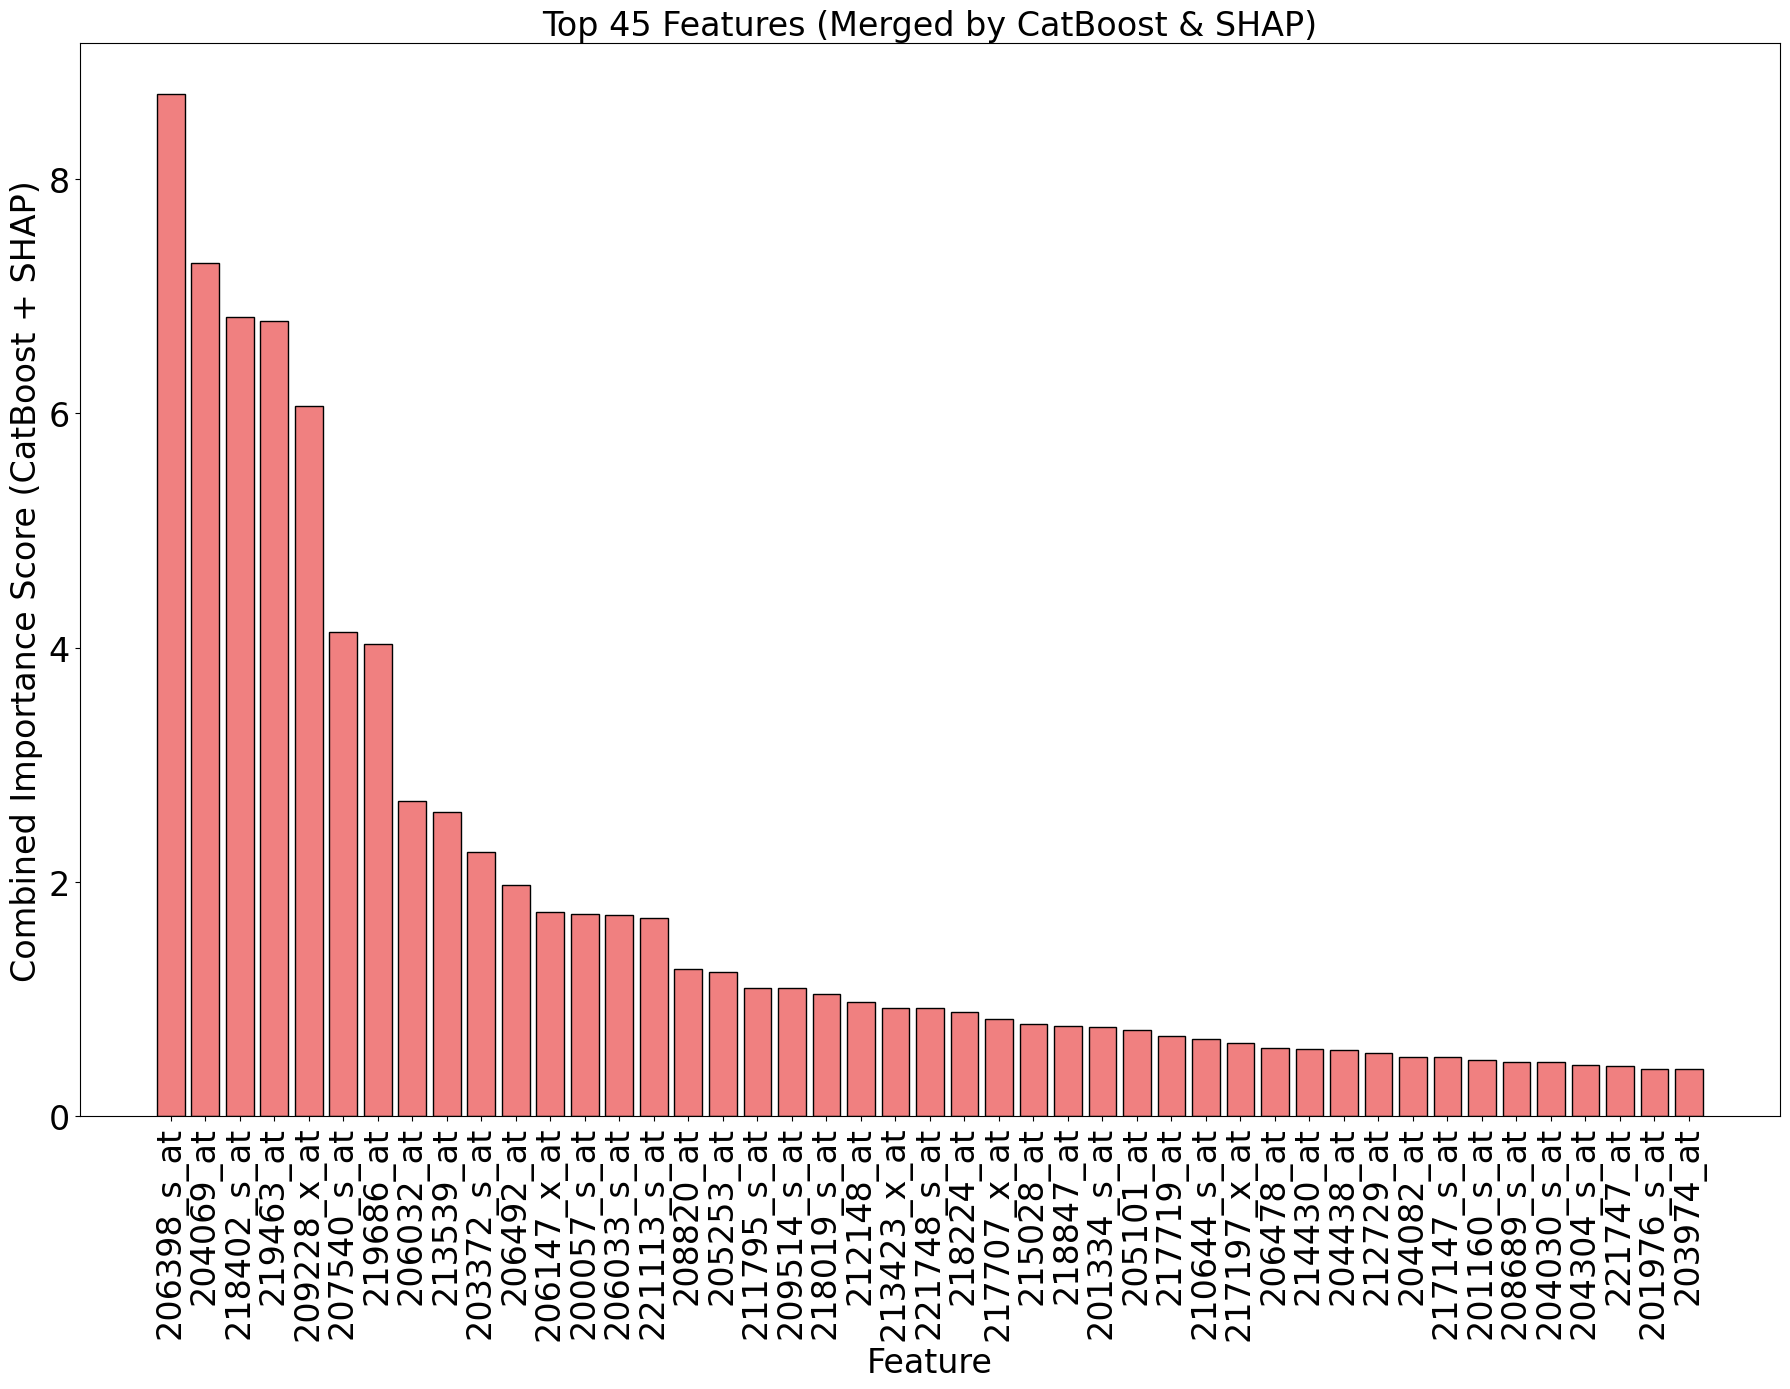

2025-07-09 10:55:12,700 - INFO - Training CNN Ensemble...
2025-07-09 10:55:12,919 - INFO - Fitting CNN Models...
2025-07-09 10:56:13,130 - INFO - CNN Ensemble trained in 60.21 seconds.
2025-07-09 10:56:13,132 - INFO - Predicting with CNN Models...
2025-07-09 10:56:14,316 - INFO - CNN Ensemble predicted in 1.18 seconds.
2025-07-09 10:56:14,318 - INFO - Calculating Evaluation Metrics...
2025-07-09 10:56:14,333 - INFO - Evaluation metrics: {'accuracy': 0.9285714285714286, 'precision': 0.8253968253968254, 'recall': 0.8571428571428571, 'f1_score': 0.8392857142857143, 'confusion_matrix': [[7, 0, 0, 0, 0, 0, 0], [0, 5, 0, 0, 0, 0, 0], [0, 0, 5, 0, 0, 0, 0], [0, 0, 0, 4, 0, 0, 0], [0, 0, 0, 0, 3, 0, 0], [2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2]]}


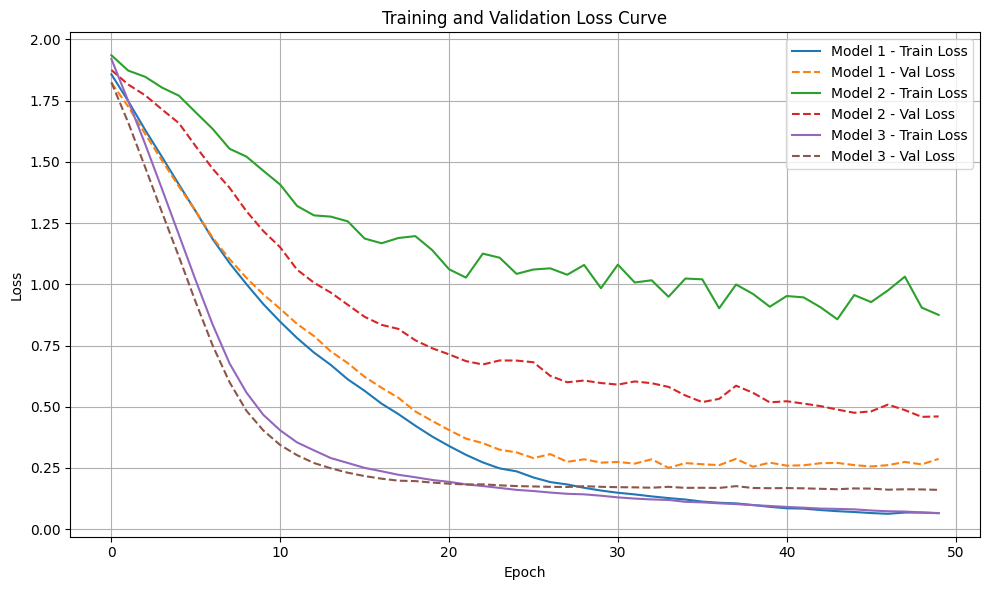

2025-07-09 10:56:16,038 - INFO - Cleaning up models...
2025-07-09 10:56:18,702 - INFO - Fold 9/10
2025-07-09 10:56:20,320 - INFO - Starting dimensionality reduction...


0:	learn: 1.7022126	total: 593ms	remaining: 1m 58s
1:	learn: 1.5322796	total: 865ms	remaining: 1m 25s
2:	learn: 1.3903268	total: 1.14s	remaining: 1m 14s
3:	learn: 1.2767332	total: 1.43s	remaining: 1m 9s
4:	learn: 1.1792674	total: 1.73s	remaining: 1m 7s
5:	learn: 1.0973566	total: 2.01s	remaining: 1m 5s
6:	learn: 1.0107542	total: 2.3s	remaining: 1m 3s
7:	learn: 0.9445772	total: 2.58s	remaining: 1m 2s
8:	learn: 0.8858968	total: 2.89s	remaining: 1m 1s
9:	learn: 0.8393297	total: 3.17s	remaining: 1m
10:	learn: 0.7879385	total: 3.48s	remaining: 59.7s
11:	learn: 0.7454782	total: 3.76s	remaining: 58.9s
12:	learn: 0.7071238	total: 4.04s	remaining: 58.1s
13:	learn: 0.6764066	total: 4.32s	remaining: 57.4s
14:	learn: 0.6482291	total: 4.61s	remaining: 56.9s
15:	learn: 0.6164352	total: 4.9s	remaining: 56.4s
16:	learn: 0.5918066	total: 5.2s	remaining: 55.9s
17:	learn: 0.5640365	total: 5.48s	remaining: 55.5s
18:	learn: 0.5429922	total: 5.75s	remaining: 54.8s
19:	learn: 0.5219129	total: 6.04s	remaining:

2025-07-09 10:57:20,895 - INFO - Calculating SHAP values...
2025-07-09 10:57:31,605 - INFO - SHAP values: Multiclass (3D Array), Shape: (253, 22283, 7)
2025-07-09 10:57:31,900 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 10:57:31,902 - INFO - Shape of shap_importance: (22283,)
2025-07-09 10:57:31,903 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 10:57:31,904 - INFO - Shape of X.columns: (22283,)
2025-07-09 10:57:31,906 - INFO - Length comparison: len(X.columns)=22283, len(shap_importance)=22283
2025-07-09 10:57:31,911 - INFO - SHAP values calculated.
2025-07-09 10:57:31,917 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_8.pkl
2025-07-09 10:57:31,919 - INFO - Dimensionality reduction completed in 71.60 seconds.


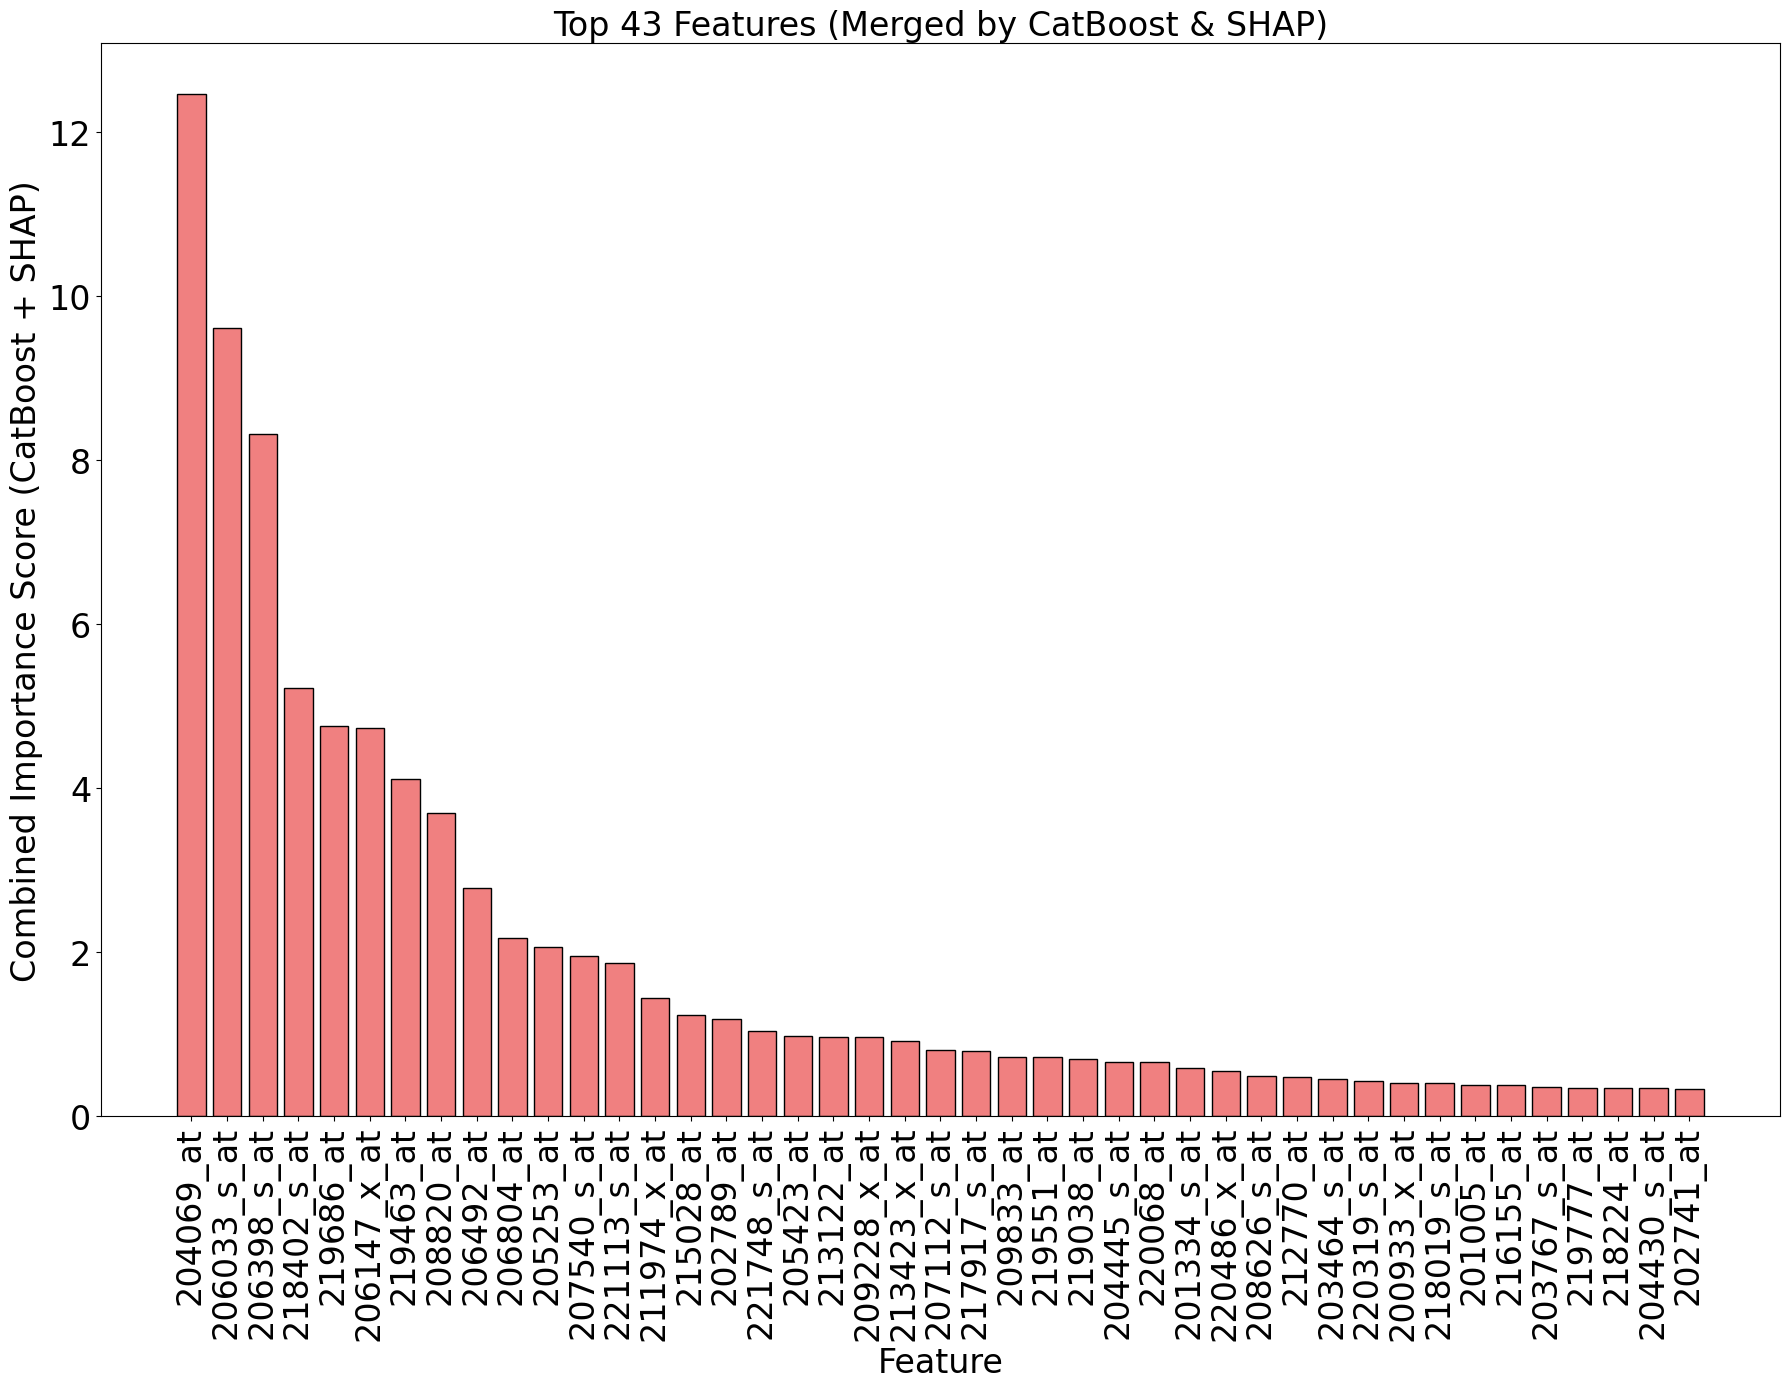

2025-07-09 10:57:33,164 - INFO - Training CNN Ensemble...
2025-07-09 10:57:33,327 - INFO - Fitting CNN Models...
2025-07-09 10:58:33,999 - INFO - CNN Ensemble trained in 60.67 seconds.
2025-07-09 10:58:34,002 - INFO - Predicting with CNN Models...
2025-07-09 10:58:35,173 - INFO - CNN Ensemble predicted in 1.17 seconds.
2025-07-09 10:58:35,174 - INFO - Calculating Evaluation Metrics...
2025-07-09 10:58:35,187 - INFO - Evaluation metrics: {'accuracy': 0.7857142857142857, 'precision': 0.7976190476190477, 'recall': 0.680952380952381, 'f1_score': 0.7076441102756893, 'confusion_matrix': [[7, 0, 0, 0, 0, 0, 0], [1, 3, 0, 0, 0, 1, 0], [0, 0, 5, 0, 0, 0, 0], [0, 0, 0, 4, 0, 0, 0], [1, 0, 0, 0, 2, 0, 0], [2, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 1]]}


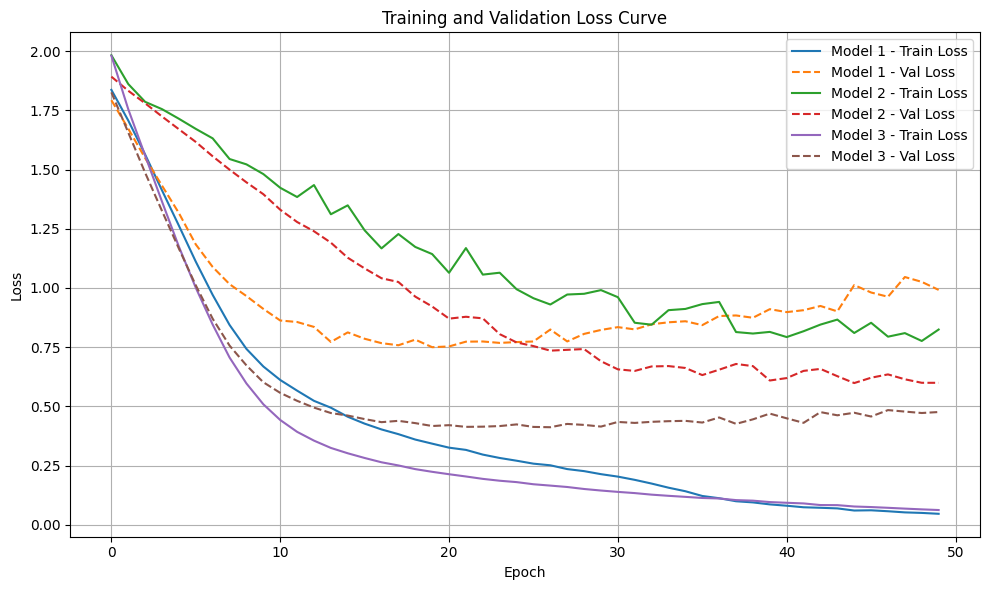

2025-07-09 10:58:35,608 - INFO - Cleaning up models...
2025-07-09 10:58:38,295 - INFO - Fold 10/10
2025-07-09 10:58:40,303 - INFO - Starting dimensionality reduction...


0:	learn: 1.7060412	total: 538ms	remaining: 1m 47s
1:	learn: 1.5283840	total: 801ms	remaining: 1m 19s
2:	learn: 1.3975804	total: 1.09s	remaining: 1m 11s
3:	learn: 1.2883212	total: 1.36s	remaining: 1m 6s
4:	learn: 1.1899331	total: 1.62s	remaining: 1m 3s
5:	learn: 1.0956515	total: 1.88s	remaining: 1m
6:	learn: 1.0196432	total: 2.16s	remaining: 59.7s
7:	learn: 0.9594213	total: 2.44s	remaining: 58.6s
8:	learn: 0.9042963	total: 2.72s	remaining: 57.8s
9:	learn: 0.8482911	total: 3s	remaining: 57.1s
10:	learn: 0.8032201	total: 3.3s	remaining: 56.7s
11:	learn: 0.7605206	total: 3.58s	remaining: 56.1s
12:	learn: 0.7228337	total: 3.86s	remaining: 55.5s
13:	learn: 0.6894409	total: 4.15s	remaining: 55.2s
14:	learn: 0.6557018	total: 4.43s	remaining: 54.7s
15:	learn: 0.6243479	total: 4.71s	remaining: 54.2s
16:	learn: 0.5978334	total: 4.99s	remaining: 53.7s
17:	learn: 0.5745003	total: 5.28s	remaining: 53.4s
18:	learn: 0.5526705	total: 5.57s	remaining: 53.1s
19:	learn: 0.5299361	total: 5.85s	remaining: 

2025-07-09 10:59:39,827 - INFO - Calculating SHAP values...
2025-07-09 10:59:50,075 - INFO - SHAP values: Multiclass (3D Array), Shape: (253, 22283, 7)
2025-07-09 10:59:50,434 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 10:59:50,435 - INFO - Shape of shap_importance: (22283,)
2025-07-09 10:59:50,437 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 10:59:50,438 - INFO - Shape of X.columns: (22283,)
2025-07-09 10:59:50,439 - INFO - Length comparison: len(X.columns)=22283, len(shap_importance)=22283
2025-07-09 10:59:50,447 - INFO - SHAP values calculated.
2025-07-09 10:59:50,453 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_9.pkl
2025-07-09 10:59:50,454 - INFO - Dimensionality reduction completed in 70.15 seconds.


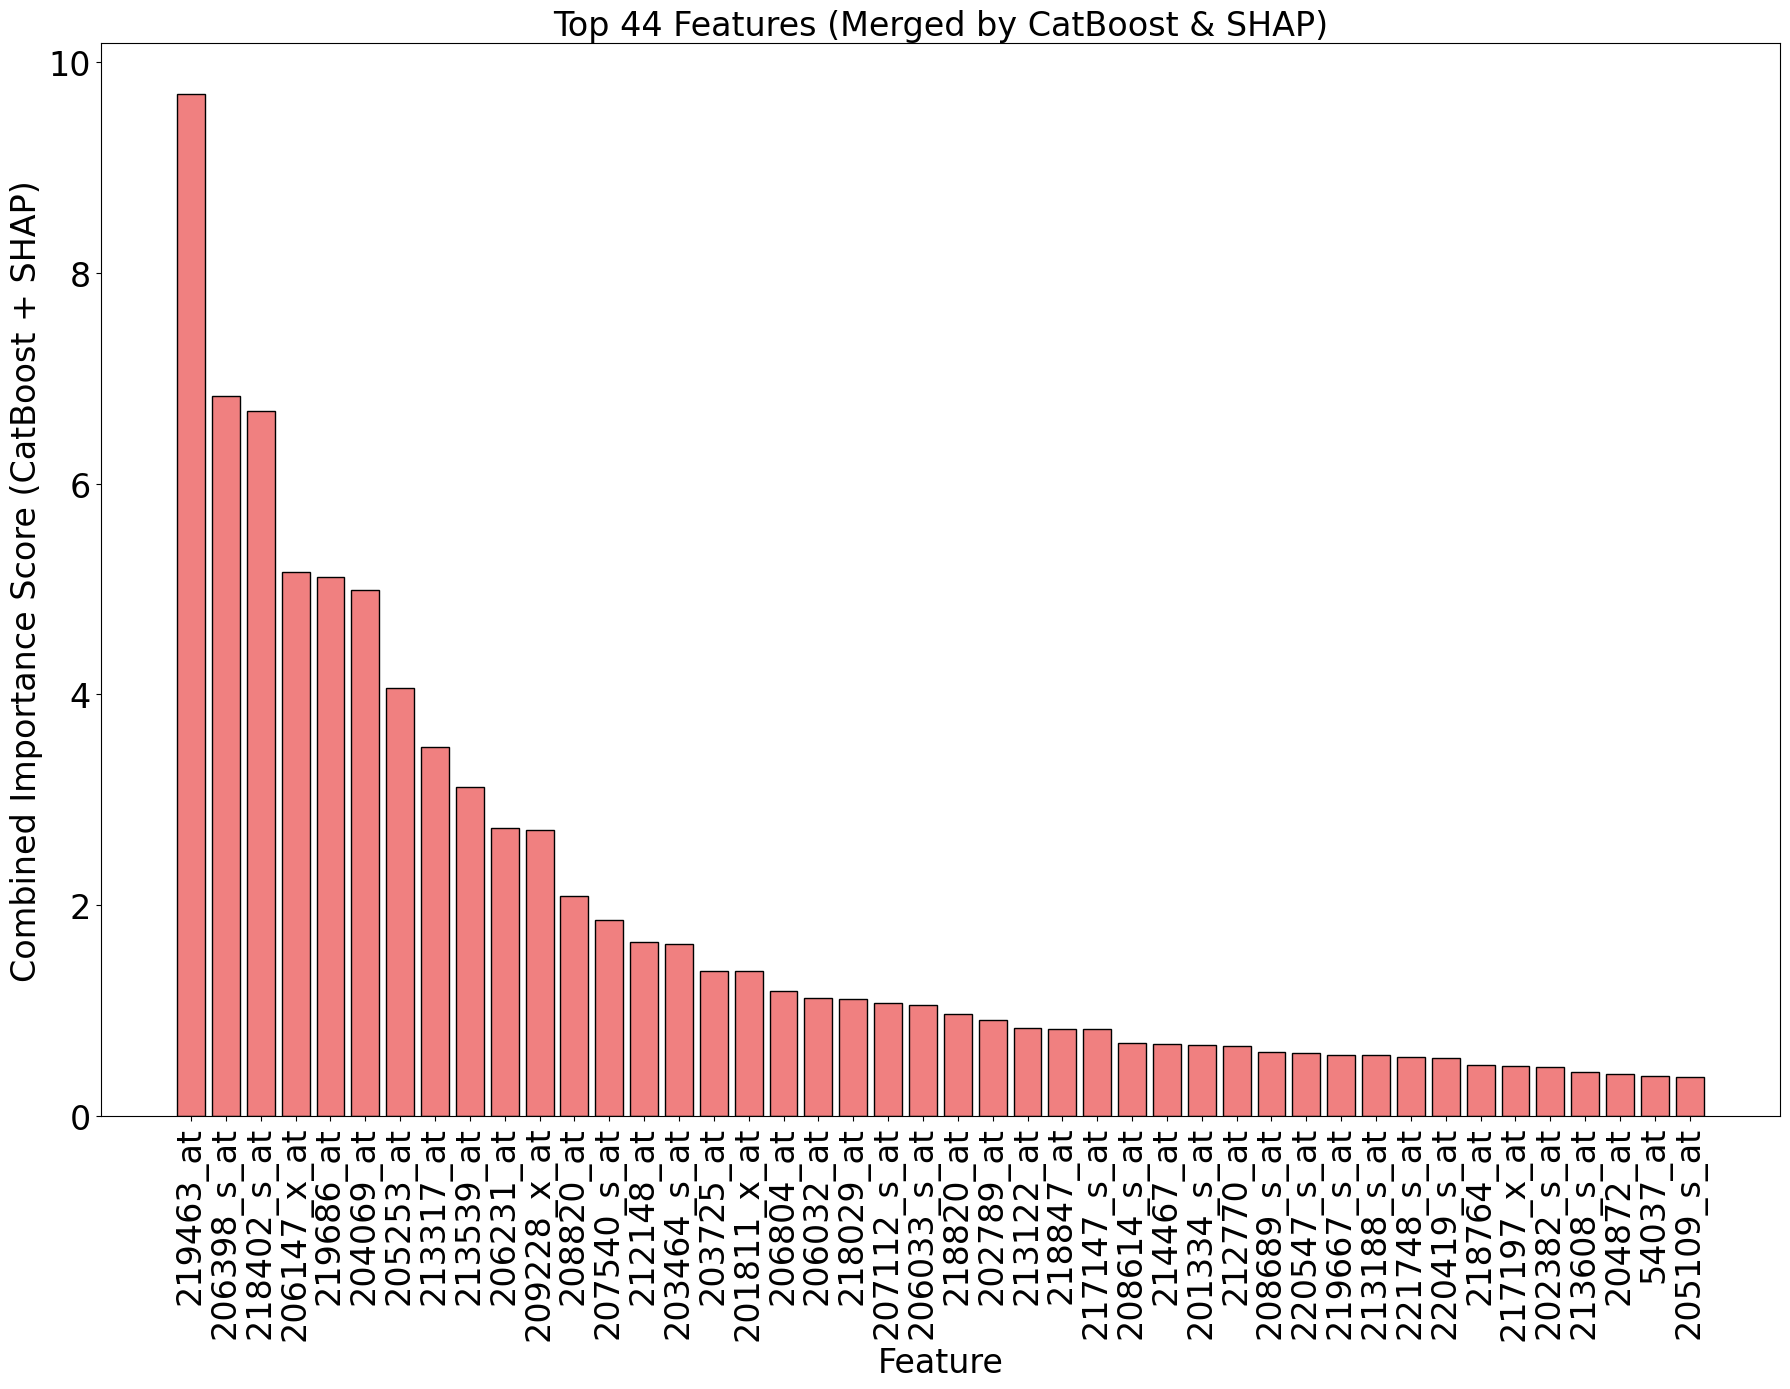

2025-07-09 10:59:51,790 - INFO - Training CNN Ensemble...
2025-07-09 10:59:51,999 - INFO - Fitting CNN Models...
2025-07-09 11:00:51,145 - INFO - CNN Ensemble trained in 59.15 seconds.
2025-07-09 11:00:51,148 - INFO - Predicting with CNN Models...
2025-07-09 11:00:52,134 - INFO - CNN Ensemble predicted in 0.99 seconds.
2025-07-09 11:00:52,135 - INFO - Calculating Evaluation Metrics...
2025-07-09 11:00:52,145 - INFO - Evaluation metrics: {'accuracy': 0.9285714285714286, 'precision': 0.8253968253968254, 'recall': 0.8571428571428571, 'f1_score': 0.8392857142857143, 'confusion_matrix': [[7, 0, 0, 0, 0, 0, 0], [0, 5, 0, 0, 0, 0, 0], [0, 0, 6, 0, 0, 0, 0], [0, 0, 0, 4, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0], [2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2]]}


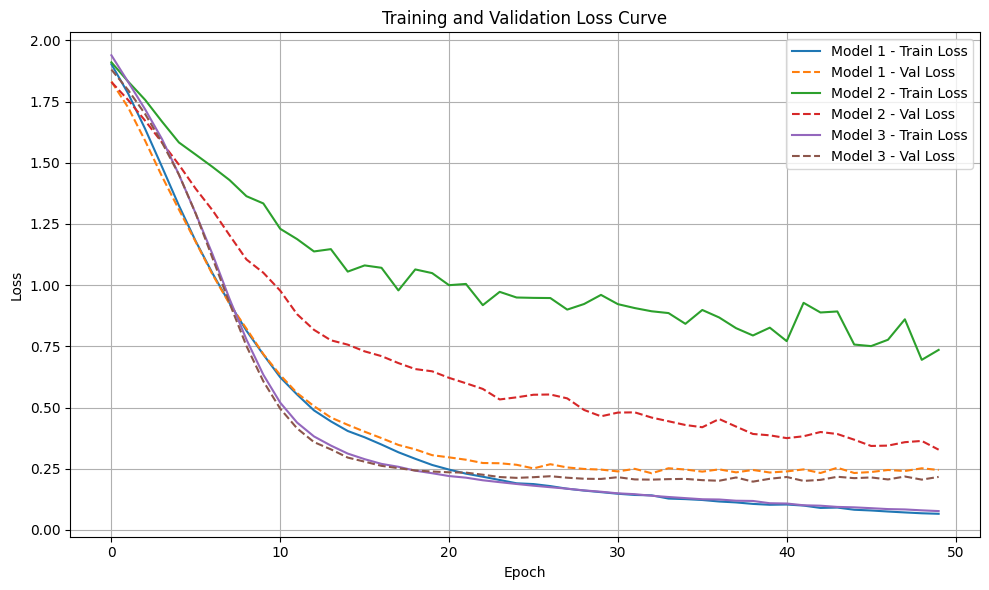

2025-07-09 11:00:52,573 - INFO - Cleaning up models...
2025-07-09 11:00:55,687 - INFO - --- Cross-Validation Completed ---
2025-07-09 11:00:55,690 - INFO - Average CNN Ensemble Metrics: {'accuracy': 0.8685960591133004, 'precision': 0.8215347351061636, 'recall': 0.8284693877551021, 'f1_score': 0.8122417079946933, 'confusion_matrix': [[62, 5, 3, 1, 0, 2, 1], [1, 50, 1, 0, 0, 1, 0], [2, 0, 46, 1, 0, 2, 0], [0, 0, 0, 46, 0, 0, 0], [1, 0, 0, 0, 21, 0, 0], [14, 1, 0, 0, 0, 3, 0], [1, 0, 0, 0, 0, 0, 16]]}


Fold 1: Training time = 22.60 s, Prediction time = 0.39 s
Fold 2: Training time = 23.78 s, Prediction time = 0.43 s
Fold 3: Training time = 32.43 s, Prediction time = 0.35 s
Fold 4: Training time = 33.63 s, Prediction time = 0.35 s
Fold 5: Training time = 60.31 s, Prediction time = 1.35 s
Fold 6: Training time = 36.50 s, Prediction time = 1.04 s
Fold 7: Training time = 23.16 s, Prediction time = 0.36 s
Fold 8: Training time = 60.21 s, Prediction time = 1.18 s
Fold 9: Training time = 60.67 s, Prediction time = 1.17 s
Fold 10: Training time = 59.15 s, Prediction time = 0.99 s

Average training time: 41.24 s
Average prediction time: 0.76 s


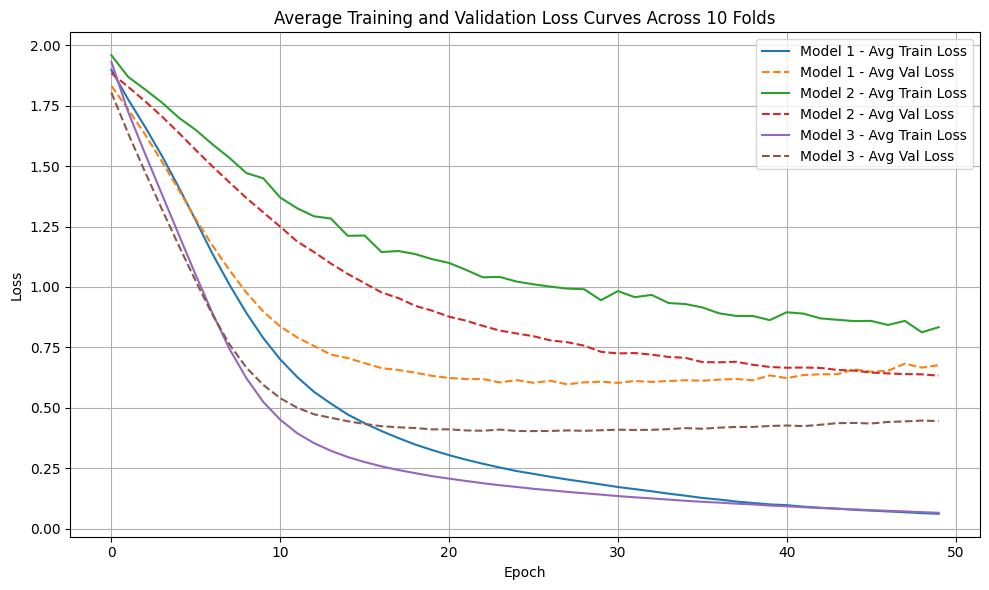

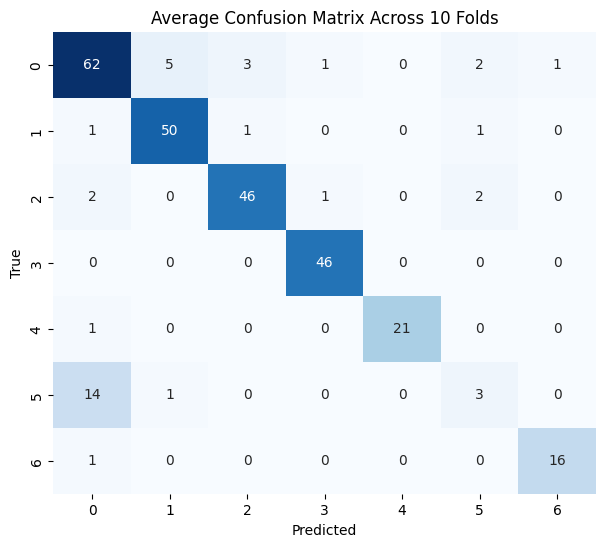

2025-07-09 11:00:56,482 - INFO - Total cross-validation execution time: 1143.86 seconds


In [51]:
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
if __name__ == '__main__':
    total_start_time = time.time()
    data_path = 'C:/Class/HK6/IPrj/Datasets/Leukemia_GSE28497.csv'

    data, X_train, y_train, X_test, y_test = load_and_preprocess_data_and_split(data_path)

    # Concatenate train and test for cross-validation
    X = pd.concat([X_train, X_test], axis=0)
    y = pd.concat([y_train, y_test], axis=0)

    # Define parameters for CNN
    params_cnn = {
        'learning_rate': 0.001,
        'epochs': 50,
        'batch_size': 32,
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    all_metrics = []
    all_training_times = []
    all_prediction_times = []
    all_histories = []

    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        logging.info(f"Fold {fold + 1}/{kf.get_n_splits()}")

        X_fold_train, X_fold_val = X.iloc[train_index], X.iloc[val_index]
        y_fold_train, y_fold_val = y.iloc[train_index], y.iloc[val_index]


        X_fold_train_reduced, selected_features, top_features_catboost, top_features_shap = reduce_dimensionality(
            X_fold_train.copy(), y_fold_train.copy(),
            save_path=f'cnn_ensemble_reduced_data_fold_{fold}.pkl'
        )
        X_fold_val_reduced = X_fold_val[selected_features]

        metrics_cnn, training_time, prediction_time, histories = train_and_evaluate_cnn_ensemble(
            X_fold_train_reduced, y_fold_train, X_fold_val_reduced, y_fold_val,
            params_cnn
        )
        all_metrics.append(metrics_cnn)
        all_training_times.append(training_time)
        all_prediction_times.append(prediction_time)
        all_histories.append(histories)

    avg_metrics = {}
    for metric in all_metrics[0]:
        if metric != 'confusion_matrix':
            avg_metrics[metric] = np.mean([fold_metrics[metric] for fold_metrics in all_metrics])
        else:
            avg_cm = np.sum([np.array(fold_metrics[metric]) for fold_metrics in all_metrics], axis=0)
            avg_metrics[metric] = avg_cm.tolist()

    logging.info("--- Cross-Validation Completed ---")
    logging.info(f"Average CNN Ensemble Metrics: {avg_metrics}")

    for fold, (train_t, pred_t) in enumerate(zip(all_training_times, all_prediction_times), 1):
        print(f"Fold {fold}: Training time = {train_t:.2f} s, Prediction time = {pred_t:.2f} s")
    
    print(f"\nAverage training time: {np.mean(all_training_times):.2f} s")
    print(f"Average prediction time: {np.mean(all_prediction_times):.2f} s")
    

    # Calculate average loss curves
    summed_train_loss = {f'model_{i+1}': np.zeros(epochs) for i in range(3)}
    summed_val_loss = {f'model_{i+1}': np.zeros(epochs) for i in range(3)}

    for fold_histories in all_histories:
        for i, history in enumerate(fold_histories):
            if history is not None: 
                # Ensure that the history lengths match 'epochs'. 
                train_loss_data = np.array(history.history['loss'])
                val_loss_data = np.array(history.history['val_loss'])
                
                # Take minimum length in case of early stopping/variations
                min_len = min(len(train_loss_data), len(val_loss_data), epochs) 
                
                summed_train_loss[f'model_{i+1}'] += train_loss_data[:min_len]
                summed_val_loss[f'model_{i+1}'] += val_loss_data[:min_len]

    # Calculate average
    avg_train_loss = {k: v / kf.n_splits for k, v in summed_train_loss.items()}
    avg_val_loss = {k: v / kf.n_splits for k, v in summed_val_loss.items()}

    # Plot average loss curves
    plt.figure(figsize=(10, 6))
    for i in range(3):
        plt.plot(avg_train_loss[f'model_{i+1}'], label=f'Model {i+1} - Avg Train Loss')
        plt.plot(avg_val_loss[f'model_{i+1}'], label=f'Model {i+1} - Avg Val Loss', linestyle='--')
    
    plt.title("Average Training and Validation Loss Curves Across 10 Folds")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
    if 'confusion_matrix' in avg_metrics:
        cm_to_plot = np.array(avg_metrics['confusion_matrix'])
        labels = all_possible_labels 
        
        plt.figure(figsize=(7, 6))
        sns.heatmap(cm_to_plot, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=labels, yticklabels=labels, cbar=False)
        plt.title("Average Confusion Matrix Across 10 Folds")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
    else:
        logging.warning("Confusion matrix not found in average metrics for plotting.")

    total_end_time = time.time()    
    total_duration = total_end_time - total_start_time
    logging.info(f"Total cross-validation execution time: {total_duration:.2f} seconds")

In [52]:
selected_features

['209228_x_at',
 '202382_s_at',
 '208689_s_at',
 '212770_at',
 '219463_at',
 '213317_at',
 '206033_s_at',
 '213188_s_at',
 '207540_s_at',
 '206804_at',
 '208614_s_at',
 '213122_at',
 '218820_at',
 '217197_x_at',
 '219667_s_at',
 '219686_at',
 '206231_at',
 '205109_s_at',
 '201811_x_at',
 '203725_at',
 '213539_at',
 '218402_s_at',
 '218847_at',
 '202789_at',
 '221748_s_at',
 '213608_s_at',
 '204872_at',
 '201334_s_at',
 '220419_s_at',
 '217147_s_at',
 '54037_at',
 '207112_s_at',
 '214467_at',
 '208820_at',
 '206147_x_at',
 '204069_at',
 '206398_s_at',
 '206032_at',
 '203464_s_at',
 '220547_s_at',
 '218764_at',
 '212148_at',
 '205253_at',
 '218029_at']